In [3]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [52]:
!pwd

/home/xiaofey/xray/xray-master/code


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from torch.utils.data import DataLoader
import timm
from timm import optim, scheduler
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import transforms as tfm
from sklearn import metrics as skmet
from jupyterplot import ProgressPlot
import matplotlib.pyplot as plt
import copy
from PIL import Image
import torch.utils.data as data_utils
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data.dataloader import default_collate
from sklearn.metrics import roc_auc_score
import torchvision.models as models
from dataset import ImageData
import torch
import os
import pickle
import load_splits
from timm import optim, scheduler
from sklearn.preprocessing import label_binarize
from torch.utils.data import Dataset
import argparse
import math

In [2]:
class ImageDataBags(Dataset):
    """Image CSV Dataset for Multiple Instance Learning"""
    type_map = {1: 0, 2: 1, 3: 2, 4: 2}
    inv_type_map = {0: '1-part', 1: '2-part', 2: '3- or 4-part'}

    def __init__(self, data: pd.DataFrame, transforms, seed=1, train=True, view_filter = None):
        self.transforms = transforms
        self.data = data
        self.train = train
        self.r = np.random.RandomState(seed=1)
        # Recode targets
        self.data['trg'] = self.data['num_parts'].map(ImageDataBags.type_map)

        # Fill nan views with "Unknown"
        self.data['view_group'] = self.data['view_group'].fillna('Unknown')
        
        # Filter to given views
        if view_filter is not None:
            self.data = self.data.loc[self.data['view_group'].isin(view_filter)]

        self.bags_list, self.labels_list, self.patient_ids_list = self._create_bags()

    def _create_bags(self):
        bags_list = []
        labels_list = []
        patient_ids_list = []  
        patient_ids = self.data['patient_id'].unique()  

        # Determine the maximum number of images in any bag based on the patient with the most images
        max_images = max(self.data.groupby('patient_id').size())
        #print(max_images)
        for patient_id in patient_ids:
            patient_data = self.data[self.data['patient_id'] == patient_id]
            # print(patient_data)
            bag_images = []
            bag_labels = []
            #print("$" * 40)
            # Fill the bag with images from the patient, applying transformations
            for idx, row in patient_data.iterrows():
                img = self.transforms(Image.open(row['path']))
                trg = row['trg']
                # print(img.shape)
                bag_images.append(img)
                bag_labels.append(trg)
                #bag_labels = [1 if label == 1 else 0 for label in bag_labels]
                C, H, W = bag_images[0].shape
            bags_list.append(torch.stack(bag_images))
            bag_label = bag_labels[0]
            labels_list.append((torch.tensor(bag_label, dtype=torch.long), torch.tensor(bag_labels, dtype=torch.long)))
            patient_ids_list.append(patient_id)
        return bags_list, labels_list, patient_ids_list
    def __len__(self):
        #print("len")
        return len(self.bags_list)
        #return len(self.labels_list)

    def __getitem__(self, index):
        bag, (bag_label, instance_labels) = self.bags_list[index], self.labels_list[index]
        patient_id = self.patient_ids_list[index]
        #print(self.labels_list[index])


        return bag, (bag_label, instance_labels, patient_id)


In [3]:
kfold = 10  # number of folds in repeated k-fold
nrepeats = 1  # number of repeats in repeated k-fold
bs_train = 15  # batch size for training
bs_test = 25  # batch size for testing
num_workers = 0  # number of parallel data loading workers
res = 224 # pixel size along height and width
device = torch.device('cuda:0')
num_classes = 3
model = 'resnet50d'
lr = 0.001
lr_gamma = 0.92
dropout = 0.3
weight_decay = 0.001
pretrained=True
keep_views = ['AP_LIKE', 'Y']
unfreeze_after_n=8

In [ ]:
parser = argparse.ArgumentParser(description="Train and evaluate the model")
parser.add_argument("--save_dir", type=str, default="/home/xiaofey/xray/xray-master/code/saved_models_test6",
                    help="Directory to save model checkpoints")
parser.add_argument("--plot_dir", type=str, default="/home/xiaofey/xray/xray-master/code/saved_models_test6",
                    help="Directory to save plot images")
parser.add_argument("--pretrained_model_dir", type=str, default="/home/xiaofey/xray/xray-master/code/test6",
                    help="Directory containing pretrained models")
args = parser.parse_args()

# Create directories if they don't exist
os.makedirs(args.save_dir, exist_ok=True)
os.makedirs(args.plot_dir, exist_ok=True)

In [4]:
df_img = pd.read_csv('../data/model_images.csv')
df_trg = pd.read_csv('../data/model_targets.csv')
random_seed = 0
# cv = RepeatedStratifiedKFold(n_splits=kfold, n_repeats=nrepeats, random_state=random_seed)
# splits = cv.split(df_trg, df_trg['fracture_type'])

In [5]:
tfms_train = tfm.Compose([
    tfm.Resize(res),
    tfm.CenterCrop(res),
    tfm.RandomEqualize(p=0.5),
    tfm.RandAugment(),
    tfm.ToTensor(),
    tfm.Normalize(mean=torch.Tensor([0.4850, 0.4560, 0.4060]), std=torch.Tensor([0.2290, 0.2240, 0.2250])),
    tfm.RandomHorizontalFlip(),
    tfm.RandomRotation((-45, 45)),
    tfm.RandomInvert(),
    tfm.Grayscale()
])

tfms_test = tfm.Compose([
    tfm.Resize(res),
    tfm.CenterCrop(res),
    tfm.ToTensor(),
    tfm.Normalize(mean=torch.Tensor([0.4850, 0.4560, 0.4060]), std=torch.Tensor([0.2290, 0.2240, 0.2250])),
    tfm.Grayscale()
])

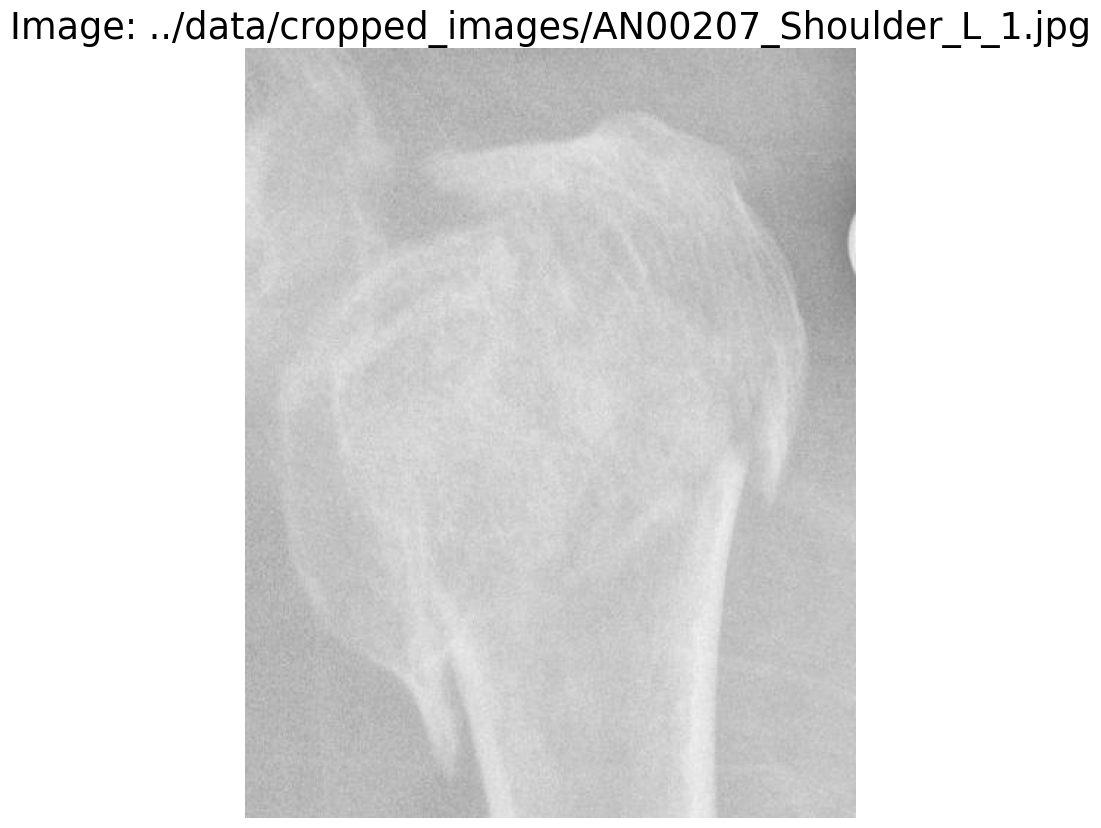

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Read the CSV file
df = pd.read_csv('../data/model_images.csv')

# Assuming the column with image paths is named 'image_path'
# If it's named differently in your CSV, replace 'image_path' with the correct column name
image_path = df['path'].iloc[329]  # Get the first image path

# Open the image
img = Image.open(image_path)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title(f"Image: {image_path}")
plt.show()

In [6]:
def collate_fn(batch):
    # print("collate_fn called")
    # Initialize empty lists for combined bags and labels
    combined_bag_images = []
    combined_instance_labels = []
    combined_bag_labels = []  # Collect all bag labels
    combined_patient_ids = []
    markers = [0]  # Start with 0, the index for the start of the first bag
    
    total_images = 0
    for bag, (bag_label, instance_labels, patient_id) in batch:
        num_images = bag.shape[0]  # Number of images in the current bag
        total_images += num_images
        combined_bag_images.append(bag)
        combined_instance_labels.append(instance_labels)
        combined_bag_labels.append(bag_label)  # Collect bag labels for each study bag
        combined_patient_ids.append(patient_id)
        markers.append(total_images)  # Append cumulative image count

    # Combine all study bags into one along the 0th dimension (number of images)
    combined_bag_images = torch.cat(combined_bag_images, dim=0)  # Combined shape: [n1 + n2 + ..., channel, h, w]
    combined_instance_labels = torch.cat(combined_instance_labels, dim=0)  # Combined instance labels

    return combined_bag_images, (combined_bag_labels, combined_instance_labels, combined_patient_ids, markers)

In [71]:
# Get one batch (first batch) from the DataLoader
one_batch = next(iter(dl_train))

# Unpack the batch (including markers)
combined_bag_images, (combined_bag_label, combined_instance_labels, combined_patient_ids, markers) = one_batch

# Print shapes and contents
print(f"Combined Bag Images Shape: {combined_bag_images.shape}")  # Shape of combined bag
print(f"Combined Bag Label: {combined_bag_label}")  # The combined bag label
print(f"Combined Instance Labels: {combined_instance_labels}")  # Instance labels for each image in the combined bag
print(f"Patient IDs: {combined_patient_ids}")  # Patient IDs for each bag
print(f"Markers: {markers}")  # Markers to indicate where each bag starts and ends within the combined bag

# Example: Separating the first and second bags based on markers
for i in range(len(markers) - 1):  # Loop through all markers
    # Extract images for the current bag
    current_bag_images = combined_bag_images[markers[i]:markers[i + 1]]
        
    # Print the shape of the current bag's images
    print(f"Bag {i + 1} Images Shape: {current_bag_images.shape}")

Combined Bag Images Shape: torch.Size([35, 1, 224, 224])
Combined Bag Label: [tensor(0), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(2), tensor(0), tensor(0), tensor(1), tensor(2), tensor(0)]
Combined Instance Labels: tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 2,
        2, 2, 0, 0, 0, 0, 0, 1, 2, 2, 0])
Patient IDs: ['AN00335', 'AN00339', 'AN00311', 'AN00104', 'AN00039', 'AN00115', 'AN00065', 'AN00097', 'AN00294', 'AN00231', 'AN00334', 'AN00218', 'AN00031', 'AN00287', 'AN00102']
Markers: [0, 1, 4, 7, 10, 13, 16, 18, 21, 23, 26, 28, 31, 32, 34, 35]
Bag 1 Images Shape: torch.Size([1, 1, 224, 224])
Bag 2 Images Shape: torch.Size([3, 1, 224, 224])
Bag 3 Images Shape: torch.Size([3, 1, 224, 224])
Bag 4 Images Shape: torch.Size([3, 1, 224, 224])
Bag 5 Images Shape: torch.Size([3, 1, 224, 224])
Bag 6 Images Shape: torch.Size([3, 1, 224, 224])
Bag 7 Images Shape: torch.Size([2, 1, 224, 224])
Bag 8 Images Shap

In [7]:
##########################################################################################
##########################################################################################
# Model Structure - Classifier with single layer


class ModifiedModel(nn.Module):
    def __init__(self, pretrained_model_path = None, num_classes=3, in_chans=1, dropout=0.3):
        super(ModifiedModel, self).__init__()
        self.M = 2048
        self.L = 128
        self.ATTENTION_BRANCHES = 1
        model = timm.create_model('resnet50d', pretrained=False, num_classes=num_classes, in_chans=in_chans, drop_rate=dropout)
        model.load_state_dict(torch.load(pretrained_model_path))
        
        self.q = nn.Parameter(torch.randn(self.M, self.ATTENTION_BRANCHES))
        self.previous_q = None 
        
        # Extract the feature extraction layers and freeze their parameters
        self.features = nn.Sequential(*list(model.children())[:-1])
        for param in self.features.parameters():
            param.requires_grad = False
        

        self.fc = list(model.children())[-1]
        for param in self.fc.parameters():
            param.requires_grad = False
        # self.classifier = nn.Sequential(
        #     nn.Linear(self.M*self.ATTENTION_BRANCHES, 3)
        # )
    def forward(self, x, markers):
        # Extract features from all images
        if self.previous_q is None:
            self.previous_q = self.q.clone().detach()
            
        S = self.features(x).squeeze()  # Shape: [total_images, 2048]
        
        h_prime_list = []
        attention_weights_list = []
        
        # Loop through each bag based on markers
        for i in range(len(markers) - 1):
            # Extract features for the current bag
            h = S[markers[i]:markers[i + 1]]  # Shape: [n_i, 2048] (n_i: number of images in the current bag)
            # print(h.shape)
            # Compute attention weights (dot product with query vector)
            lamb = torch.matmul(h, self.q) # [n_i, branches]
            att = torch.softmax(lamb, dim=0)  # [n_i, branches]
            # print(att.shape)
            # Apply attention: weighted sum of features for the current bag
            h_prime = torch.matmul(att.T, h)   # [branches, 2048]
            h_prime = h_prime.squeeze(0)  # warning: might not generalize when branches > 1
            # print(h_prime.shape)
            # Store the result for this bag
            h_prime_list.append(h_prime)
            attention_weights_list.append(att)
        # Stack all h_prime tensors to form h_tol with shape [num_bags, 2048]
        h_tol = torch.stack(h_prime_list, dim=0)  # Shape: [num_bags, 2048]
        
        # Pass h_tol through the classifier to get the logits (predictions)
        logits = self.fc(h_tol)  # Shape: [num_bags, num_classes]
        Y_hat = torch.argmax(logits, dim=1)
        return logits, attention_weights_list, Y_hat
    
    def calculate_classification_error(self, X, Y, markers):
        _, _, Y_hat = self.forward(X, markers)
        error = 1.0 - Y_hat.eq(Y).float().mean().item()

        return error
    
    def check_attention_convergence(self):
        with torch.no_grad():
            q_diff_norm = torch.norm(self.q - self.previous_q)
            self.previous_q = self.q.clone().detach()
        return q_diff_norm.item()

In [110]:
class ModifiedModel(nn.Module):
    def __init__(self, pretrained_model_path = None, num_classes=3, in_chans=1, dropout=0.3):
        super(ModifiedModel, self).__init__()
        self.M = 2048
        self.L = 128
        self.ATTENTION_BRANCHES = 1
        self.subspace_size = self.M // self.ATTENTION_BRANCHES
        self._scale = math.sqrt(self.subspace_size)
        
        model = timm.create_model('resnet50d', pretrained=False, num_classes=num_classes, in_chans=in_chans, drop_rate=dropout)
        model.load_state_dict(torch.load(pretrained_model_path))
        
        self.q = nn.Parameter(torch.randn(self.ATTENTION_BRANCHES, self.subspace_size))
        self.previous_q = None 
        
        # Extract the feature extraction layers and freeze their parameters
        self.features = nn.Sequential(*list(model.children())[:-1])
        for param in self.features.parameters():
            param.requires_grad = False
        

        self.fc = list(model.children())[-1]
        for param in self.fc.parameters():
            param.requires_grad = False
        # self.classifier = nn.Sequential(
        #     nn.Linear(self.M*self.ATTENTION_BRANCHES, 3)
        # )
    def forward(self, x, markers):
        # Extract features from all images
        if self.previous_q is None:
            self.previous_q = self.q.clone().detach()
            
        S = self.features(x).squeeze()  # Shape: [total_images, 2048]
        
        h_prime_list = []
        attention_weights_list = []
        
        # Loop through each bag based on markers
        for i in range(len(markers) - 1):
            # Extract features for the current bag
            h = S[markers[i]:markers[i + 1]]  # Shape: [n_i, 2048] (n_i: number of images in the current bag)
            # print(h.shape)
            # Compute attention weights (dot product with query vector)
            h_vid, attn = self.attention_pool(h)

            h_prime_list.append(h_vid)
            attention_weights_list.append(attn)
            
        # Stack all h_prime tensors to form h_tol with shape [num_bags, 2048]
        h_tol = torch.stack(h_prime_list, dim=0)  # Shape: [num_bags, 2048]
        # Pass h_tol through the classifier to get the logits (predictions)
        logits = self.fc(h_tol).squeeze(1)  # Shape: [num_bags, num_classes]
        Y_hat = torch.argmax(logits, dim=1)
        return logits, attention_weights_list, Y_hat
    
    def attention_pool(self, h):
        # Reshape input for multi-head attention
        h_query = h.view(-1, self.ATTENTION_BRANCHES, self.subspace_size)
        
        # Compute attention logits
        alpha = (h_query * self.q).sum(axis=-1) / self._scale
        
        # Normalize attention weights
        attn = torch.softmax(alpha, dim=0)

        # Apply attention and pool
        h_vid = torch.sum(h_query * attn.unsqueeze(-1), dim=0)
        
        # Reshape to combine all heads
        h_vid = h_vid.view(-1, self.M)
        
        return h_vid, attn
    
    def calculate_classification_error(self, X, Y, markers):
        _, _, Y_hat = self.forward(X, markers)
        error = 1.0 - Y_hat.eq(Y).float().mean().item()

        return error
    
    def check_attention_convergence(self):
        with torch.no_grad():
            q_diff_norm = torch.norm(self.q - self.previous_q)
            self.previous_q = self.q.clone().detach()
        return q_diff_norm.item()

In [21]:
# m = ModifiedModel(pretrained_model_path = 'fine_tuned_model_split_1.pth', num_classes=3)
# m

ModifiedModel(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [111]:
def check_frozen_parameters(model):
    frozen_layers = []
    trainable_layers = []
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable_layers.append(name)
        else:
            frozen_layers.append(name)
    
    print("Frozen Layers:")
    for layer in frozen_layers:
        print(f"{layer}: Frozen (requires_grad=False)")
    
    print("\nTrainable Layers:")
    for layer in trainable_layers:
        print(f"{layer}: Trainable (requires_grad=True)")


In [112]:
def train_one_epoch(model, train_dataloader, device):
    model.train()
    train_loss = 0.
    train_error = 0.
    for batch_idx, (data, (bag_label, instance_labels, _, markers)) in enumerate(train_dataloader):
        data = data.to(device)
        bag_label = torch.stack(bag_label).to(device)
        markers = markers
        optimizer.zero_grad()
        
        logits, attention_weights, _ = model(data, markers)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, bag_label)
        error = model.calculate_classification_error(data, bag_label, markers)
        train_loss += loss.item()
        train_error += error
        loss.backward()
        optimizer.step()
        q_diff = model.check_attention_convergence()
    # calculate loss and error for epoch
    num_samples = len(train_dataloader)
    train_loss /= num_samples
    train_error /= num_samples
    print('Loss: {:.4f}, Train error: {:.4f}, Q Diff:{:.4f}'.format(train_loss, train_error, q_diff))
    return train_loss, train_error

In [113]:
import sklearn.metrics as skmet
from sklearn.preprocessing import label_binarize
def evaluate(model, test_dataloader, device):
    model.eval()
    test_loss = 0.
    test_error = 0.
    all_labels = []
    all_predictions = []
    batch_info_list = []  # List to hold information for each batch

    with torch.no_grad():
        for batch_idx, (data, (bag_label, instance_labels, patient_id, markers)) in enumerate(test_dataloader):
            data, bag_label, instance_labels, patient_id = data.to(device), torch.stack(bag_label).to(device), instance_labels.to(device), patient_id
            markers = markers
            
            logits, attention_weights, predicted_label = model(data, markers)
            
            criterion = nn.CrossEntropyLoss()
            loss = criterion(logits, bag_label)
            error = model.calculate_classification_error(data, bag_label, markers)
            test_loss += loss.item()
            test_error += error
            attention_weights_numpy = []
            for attention in attention_weights:
                attention_weights_numpy.append(attention.cpu().numpy())  # Convert each bag's attention weights to NumPy
                
            # Store all labels and predictions
            all_labels.extend(bag_label.cpu().numpy())
            all_predictions.extend(logits.cpu().numpy()) 
            # Collecting information for the current batch
            batch_info = {
                'patient_id': patient_id,
                'attention_weights': attention_weights_numpy,
                'images': data.cpu().data.numpy(),
                'labels': bag_label.cpu().data.numpy(),
                'instance_labels': instance_labels.cpu().data.numpy(),
                'predicted_labels': predicted_label.cpu().data.numpy(),
                'markers': markers
            }
            batch_info_list.append(batch_info)  # Appending current batch's information to the list
    num_samples = len(test_dataloader)
    test_error /= num_samples
    test_loss /= num_samples

    all_labels = np.array(all_labels).reshape(-1, 1)  # Ensure all_labels is a 2D array

    logits = torch.tensor(np.array(all_predictions))
    all_predictions = torch.softmax(logits, dim=1).cpu().numpy()
    predicted_labels = np.argmax(all_predictions, axis=1)

    y_true_onehot = label_binarize(all_labels, classes=[0, 1, 2]) 

    roc_auc = skmet.roc_auc_score(y_true_onehot, all_predictions, multi_class='ovr')

    average_precision = skmet.average_precision_score(y_true_onehot, all_predictions)
    accuracy = skmet.accuracy_score(all_labels, predicted_labels)
    balanced_accuracy = skmet.balanced_accuracy_score(all_labels, predicted_labels)

    print('\nTest Set, Loss: {:.4f}, Test error: {:.4f}, AUC: {:.4f}, Average Precision: {:.4f}, Accuracy: {:.4f}, Balanced Accuracy: {:.4f}'.format(
        test_loss, test_error, roc_auc, average_precision, accuracy, balanced_accuracy))
    
    return test_loss, test_error, roc_auc, average_precision, accuracy, balanced_accuracy, batch_info_list

In [114]:
num_epochs=10
with open('cv_splits.pkl', 'rb') as f:
    saved_splits = pickle.load(f)

In [115]:
import torch.optim as optim
import os
split_results = []
# splits = cv.split(df_trg, df_trg['fracture_type'])
unfreeze_after_n=8
save_dir = '/home/xiaofey/xray/xray-master/code/test1'
# pretrained_model_dir = '/home/xiaofey/xray/xray-master/code/saved_models/test'
pretrained_model_dir = '/home/xiaofey/xray/xray-master/code/test6'

for ix, (train_ix, test_ix) in enumerate(saved_splits):
    print('-'*40)
    print(f"Split {ix+1} of {kfold*nrepeats}.")
    
    pretrained_model_path = os.path.join(pretrained_model_dir, f'loss_and_metrics_split_test6_{ix+1}.pth')
    if os.path.exists(pretrained_model_path):
        print(f"Loading pretrained model for Split {ix+1} from {pretrained_model_path}")
        m = ModifiedModel(pretrained_model_path=pretrained_model_path)
    else:
        print(f"No pretrained model found for Split {ix+1}, starting from scratch.")
        # m = ModifiedModel(num_classes=3, in_chans=1, dropout=0.3)  # Define your model from scratch

    m.to(device)  
    
    
    df_train = df_trg.iloc[train_ix].merge(df_img)
    df_test = df_trg.iloc[test_ix].merge(df_img)
    
    # create datasets
    d_train = ImageDataBags(df_train, transforms = tfms_train, view_filter=keep_views)
    dl_train = DataLoader(d_train, batch_size=bs_train, num_workers=num_workers, shuffle=True, collate_fn=collate_fn)
    
    d_test = ImageDataBags(df_test, transforms = tfms_test, view_filter=keep_views)
    dl_test = DataLoader(d_test, batch_size=bs_test, num_workers=num_workers, collate_fn=collate_fn)

    is_frozen=True
    # fit
    optimizer = optim.Adam(m.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = ExponentialLR(optimizer, gamma=lr_gamma)
    loss_function = torch.functional.F.cross_entropy
    
    train_loss_ls = []
    train_error_ls = []
    test_loss_ls = []
    test_error_ls = []
    roc_auc_ls = []
    avg_precision_ls = []
    accuracy_ls = []
    balanced_accuracy_ls = []
    batch_info_ls = []
    
    
    best_test_loss = 1e10
    state_dict = None
    for epoch in range(num_epochs):
        #print("-"*40)
        print(f"\rEpoch {epoch+1} of {num_epochs}:", end='')

        # if epoch >= unfreeze_after_n and is_frozen:
        #     print("Unfreezing model encoder.")
        #     is_frozen=False
        #     for p in m.parameters():
        #         p.requires_grad = True
        
        
        # train for a single epoch
        # test_loss, test_error, roc_auc, avg_precision, accuracy, balanced_accuracy, batch_info_list = evaluate(m, dl_test, device)
        train_loss, train_error = train_one_epoch(m, dl_train, device)
        train_loss_ls.append(train_loss)
        # train_error_ls.append(train_error)
        #print(f"Training:")
        #print(f"\tcross_entropy = {train_loss:0.3f}")       
    
        # evaluate
        # test_loss, auc_score, test_error, batch_info_list = evaluate(m, dl_test, device)
        test_loss, test_error, roc_auc, avg_precision, accuracy, balanced_accuracy, batch_info_list = evaluate(m, dl_test, device)
        test_loss_ls.append(test_loss)
        roc_auc_ls.append(roc_auc)
        avg_precision_ls.append(avg_precision)
        accuracy_ls.append(accuracy)
        balanced_accuracy_ls.append(balanced_accuracy)
        batch_info_ls.append(batch_info_list)
        
        # save weights if improved
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            state_dict = copy.deepcopy(m.state_dict())
        
        scheduler.step()
        
    model_save_path = os.path.join(save_dir, f'fine_tuned_model_split_test_{ix+1}.pth')
    torch.save(state_dict, model_save_path)
    
    split_results.append({
        'split_ix': ix, 
        'best_test_loss': best_test_loss, 
        'state_dict': state_dict,
        'train_ix': train_ix,
        'test_ix': test_ix,
        'train_loss': train_loss_ls, 
        'test_loss': test_loss_ls,
        'roc_auc': roc_auc_ls,
        'average_precision': avg_precision_ls,
        'accuracy': accuracy_ls,
        'balanced_accuracy': balanced_accuracy_ls,
        'batch_info': batch_info_ls
    })

----------------------------------------
Split 1 of 10.
Loading pretrained model for Split 1 from /home/xiaofey/xray/xray-master/code/test6/loss_and_metrics_split_test6_1.pth
Epoch 1 of 10:Loss: 0.8825, Train error: 0.4068, Q Diff:0.0214

Test Set, Loss: 0.8846, Test error: 0.4892, AUC: 0.7818, Average Precision: 0.6952, Accuracy: 0.5263, Balanced Accuracy: 0.5299
Epoch 2 of 10:Loss: 0.8897, Train error: 0.4174, Q Diff:0.0193

Test Set, Loss: 0.8848, Test error: 0.4308, AUC: 0.7880, Average Precision: 0.6865, Accuracy: 0.5789, Balanced Accuracy: 0.5812
Epoch 3 of 10:Loss: 0.9003, Train error: 0.4077, Q Diff:0.0178

Test Set, Loss: 0.8793, Test error: 0.4123, AUC: 0.7786, Average Precision: 0.6914, Accuracy: 0.5789, Balanced Accuracy: 0.5812
Epoch 4 of 10:Loss: 0.9122, Train error: 0.4483, Q Diff:0.0159

Test Set, Loss: 0.8903, Test error: 0.4123, AUC: 0.7779, Average Precision: 0.6867, Accuracy: 0.5789, Balanced Accuracy: 0.5812
Epoch 5 of 10:Loss: 0.8979, Train error: 0.4116, Q Diff:0

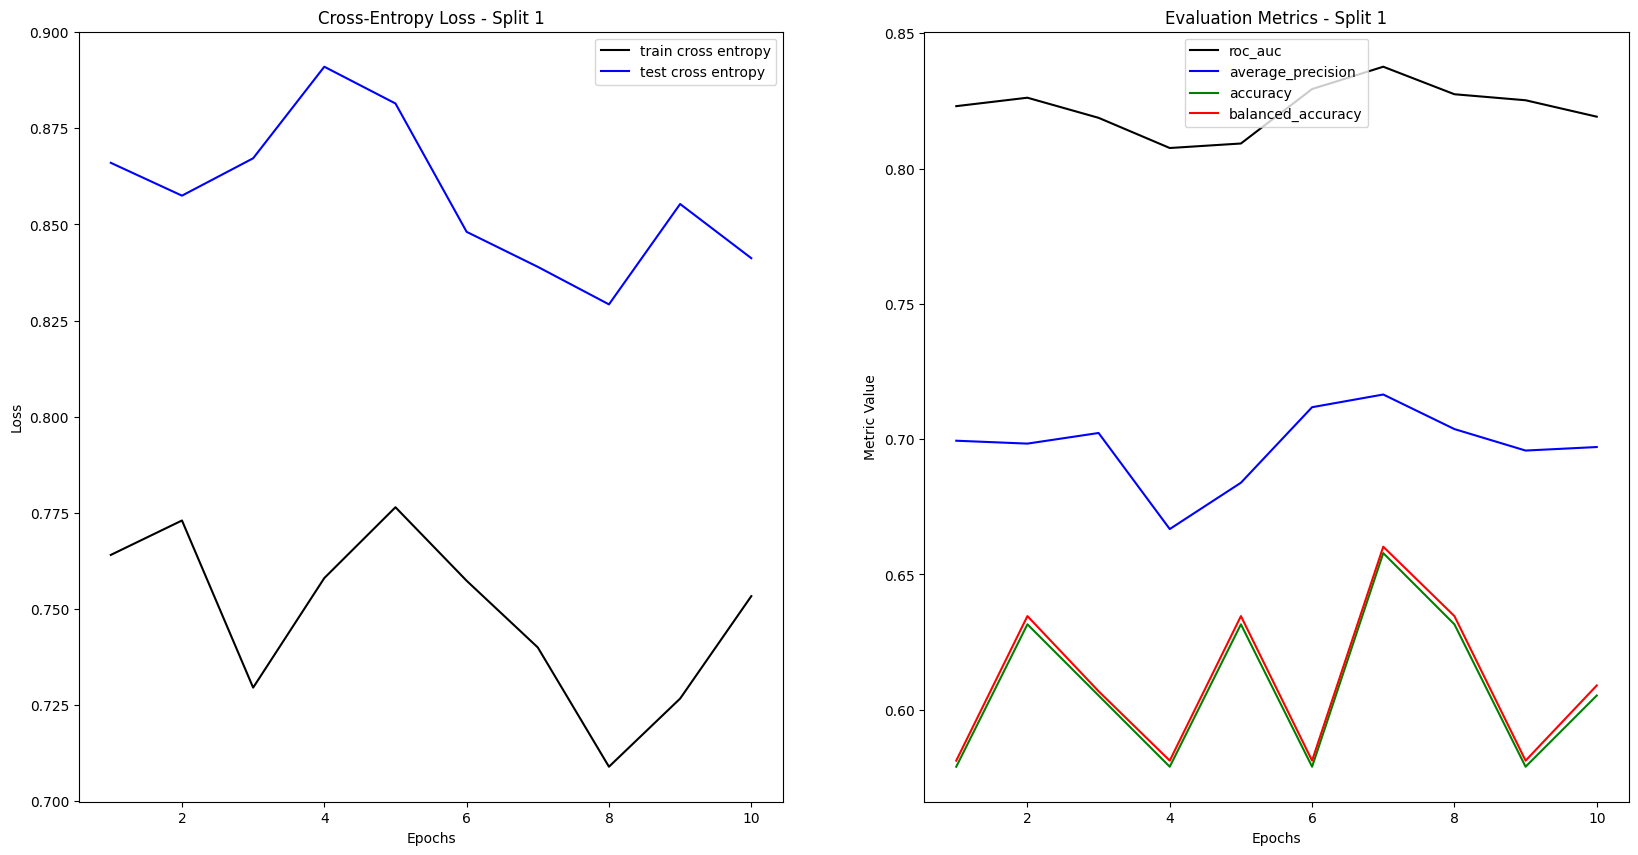

<Figure size 640x480 with 0 Axes>

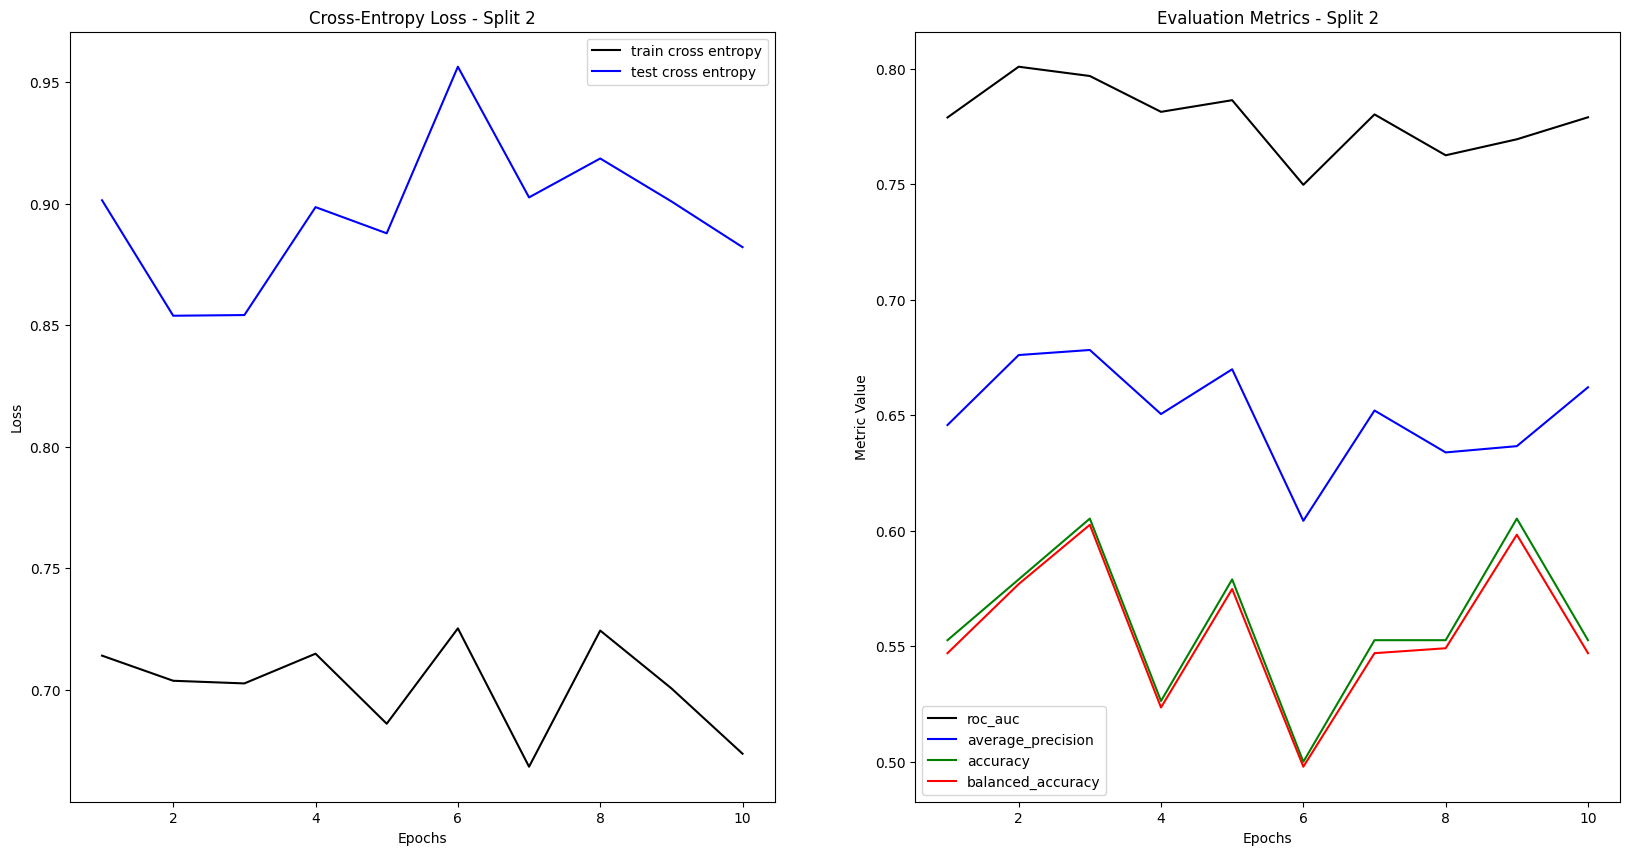

<Figure size 640x480 with 0 Axes>

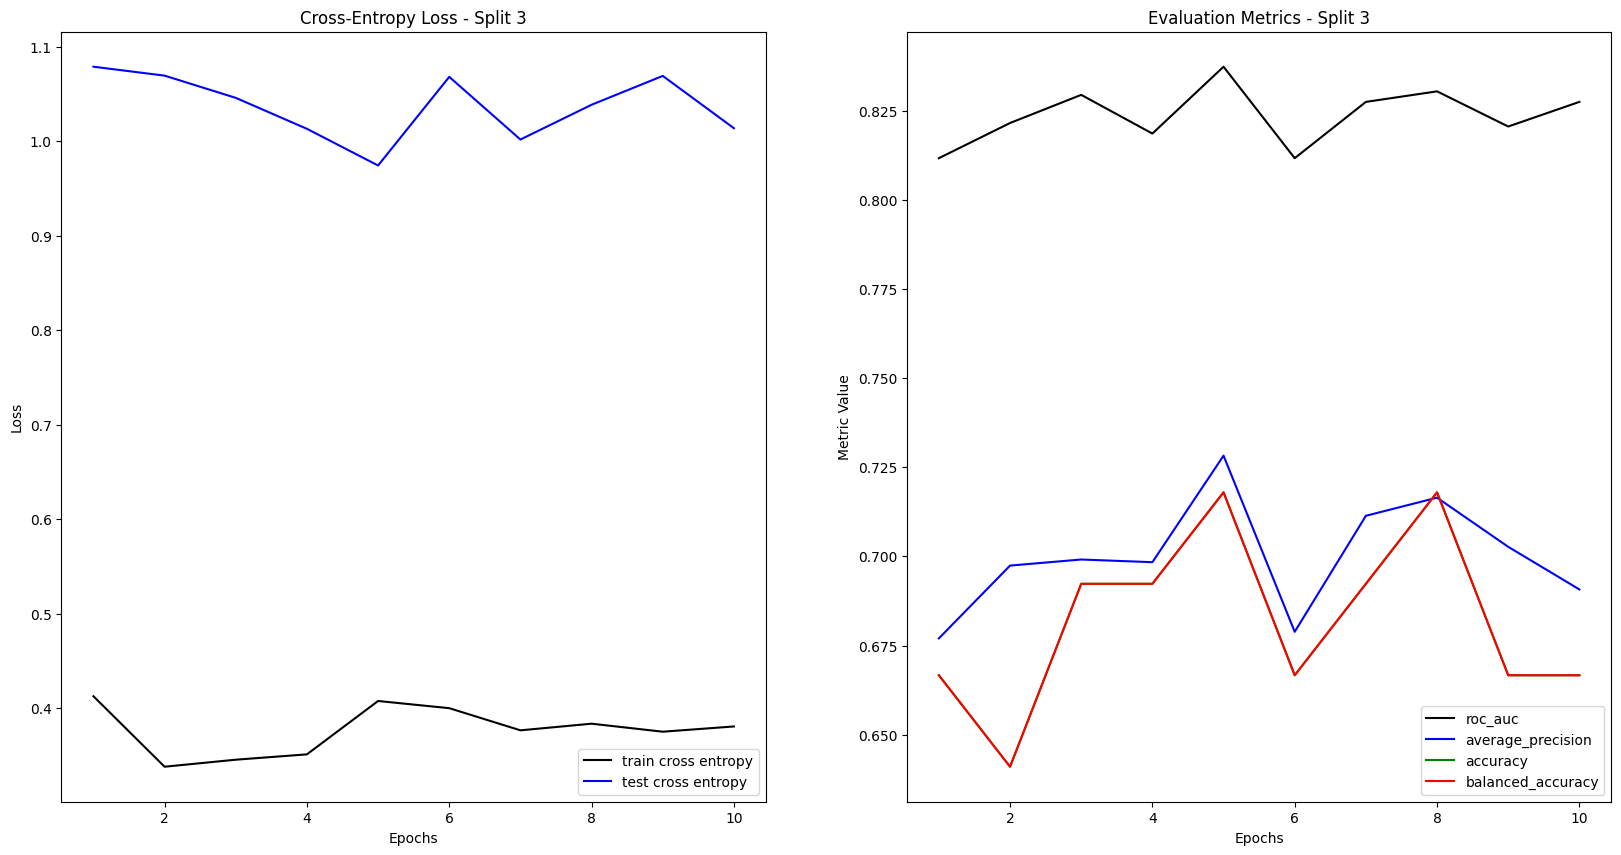

<Figure size 640x480 with 0 Axes>

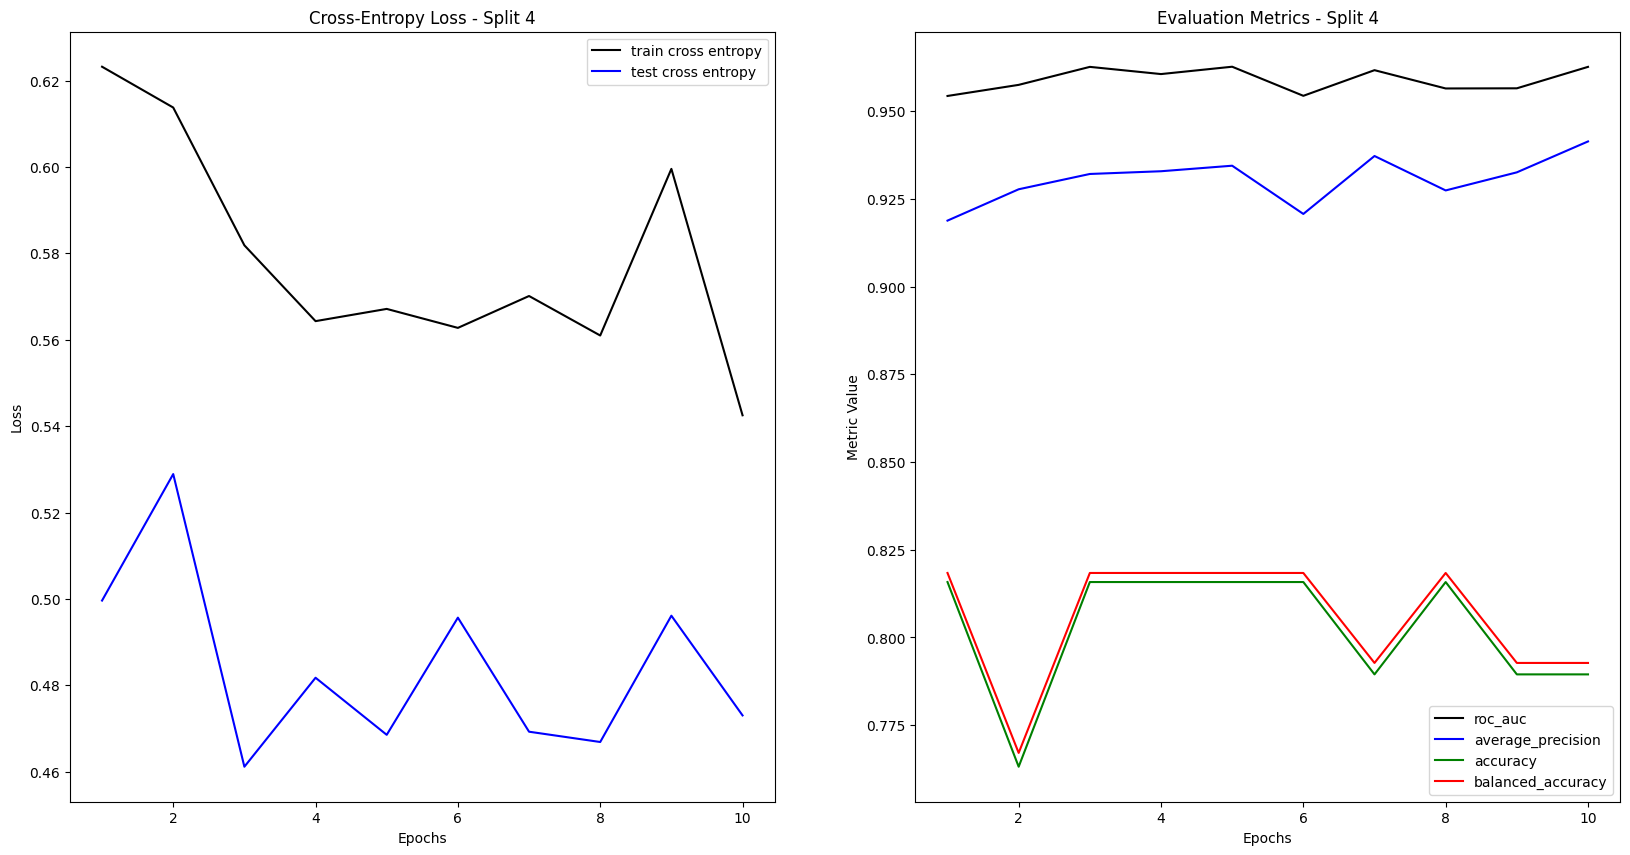

<Figure size 640x480 with 0 Axes>

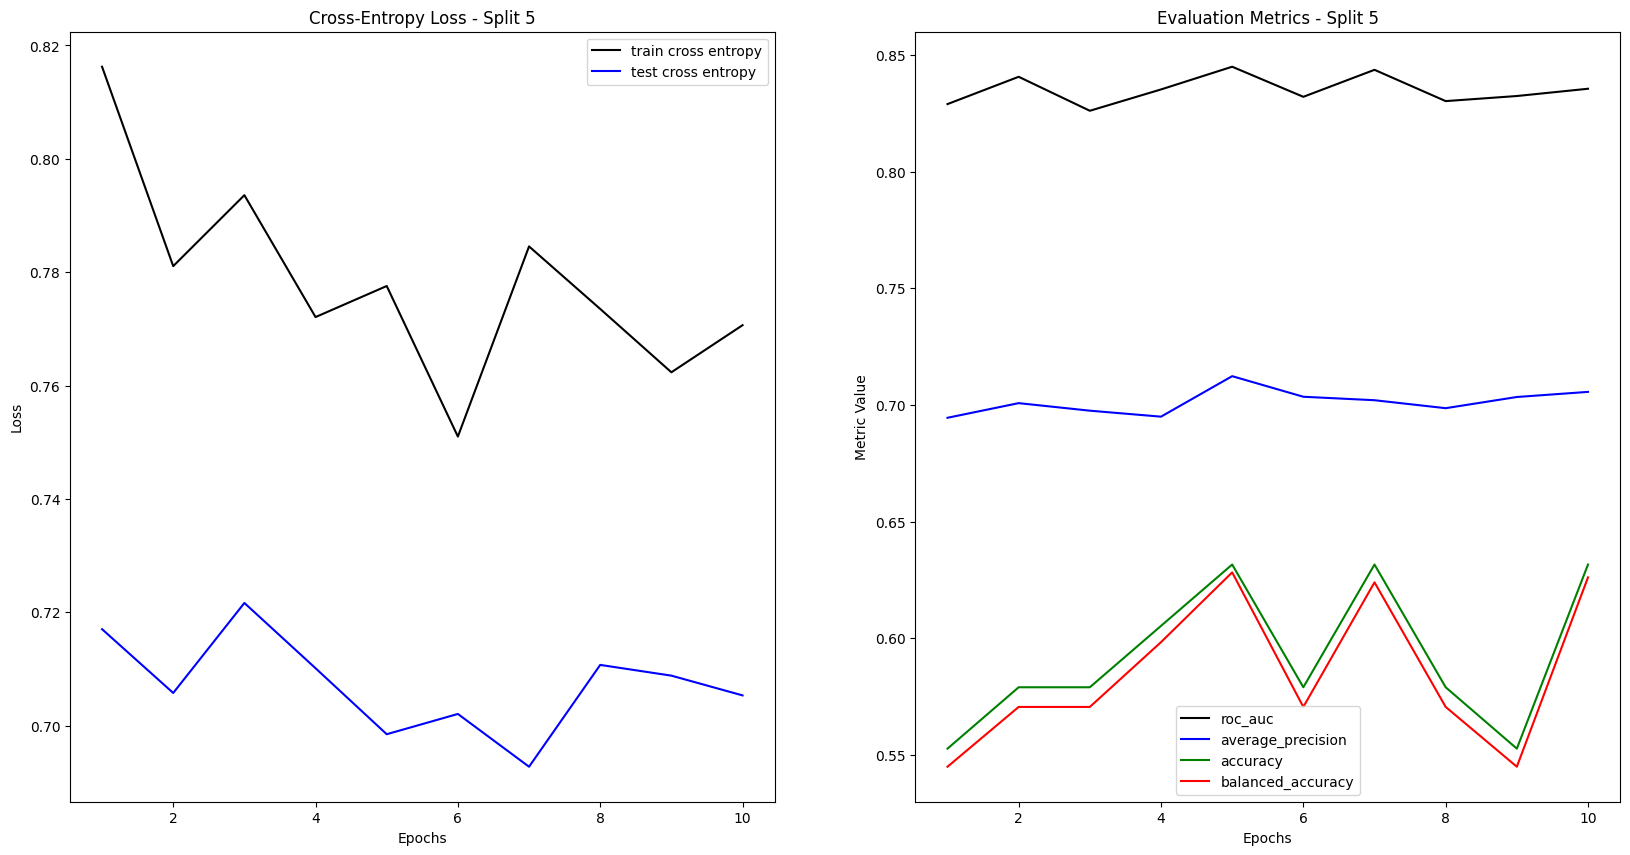

<Figure size 640x480 with 0 Axes>

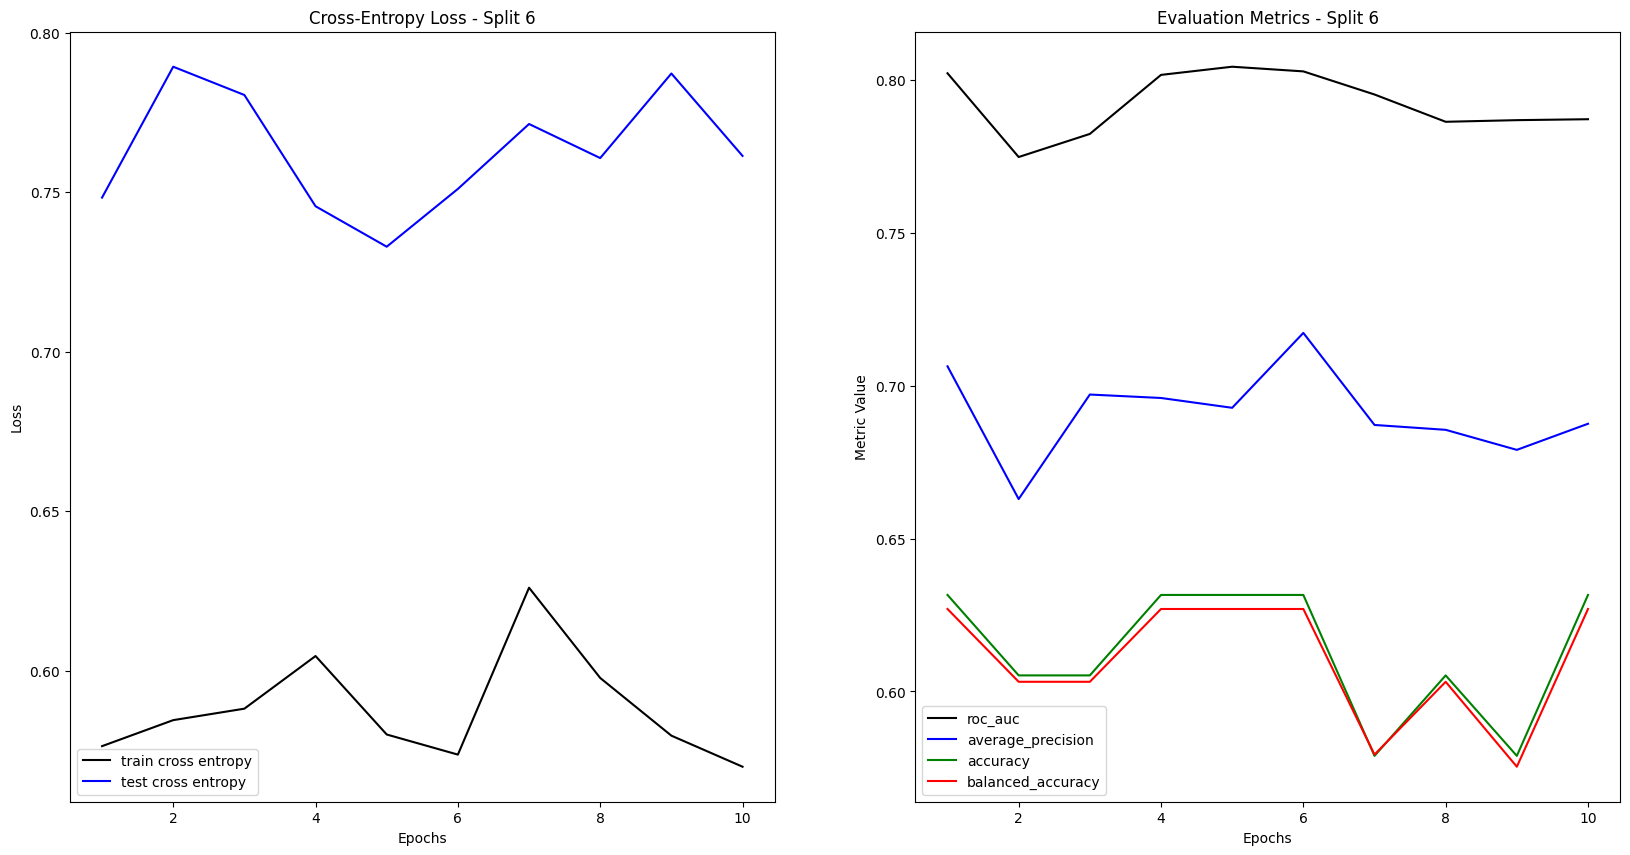

<Figure size 640x480 with 0 Axes>

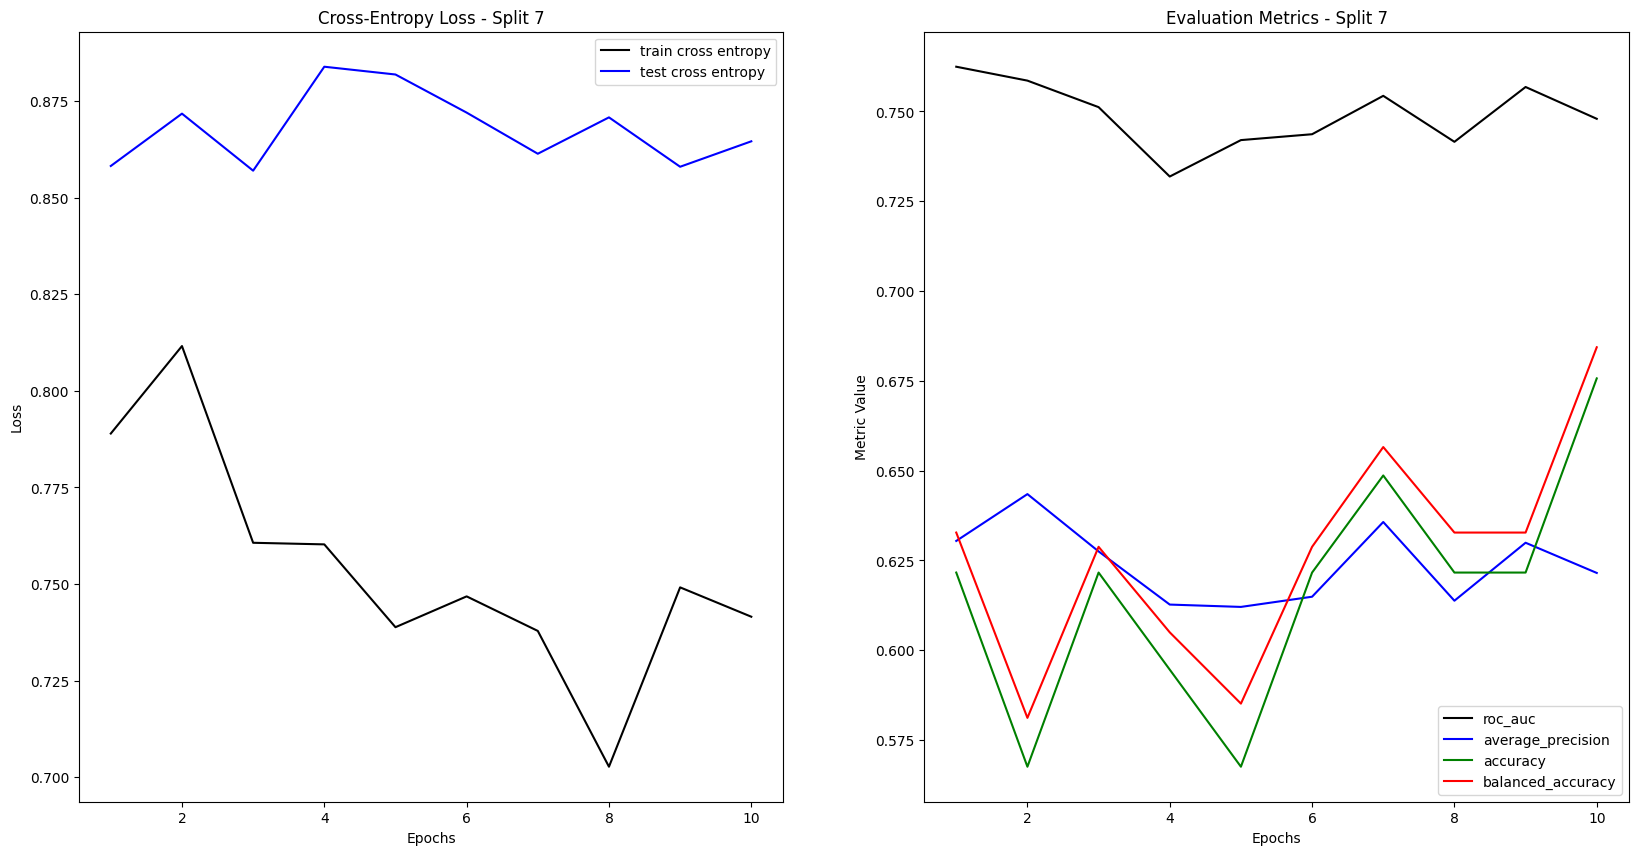

<Figure size 640x480 with 0 Axes>

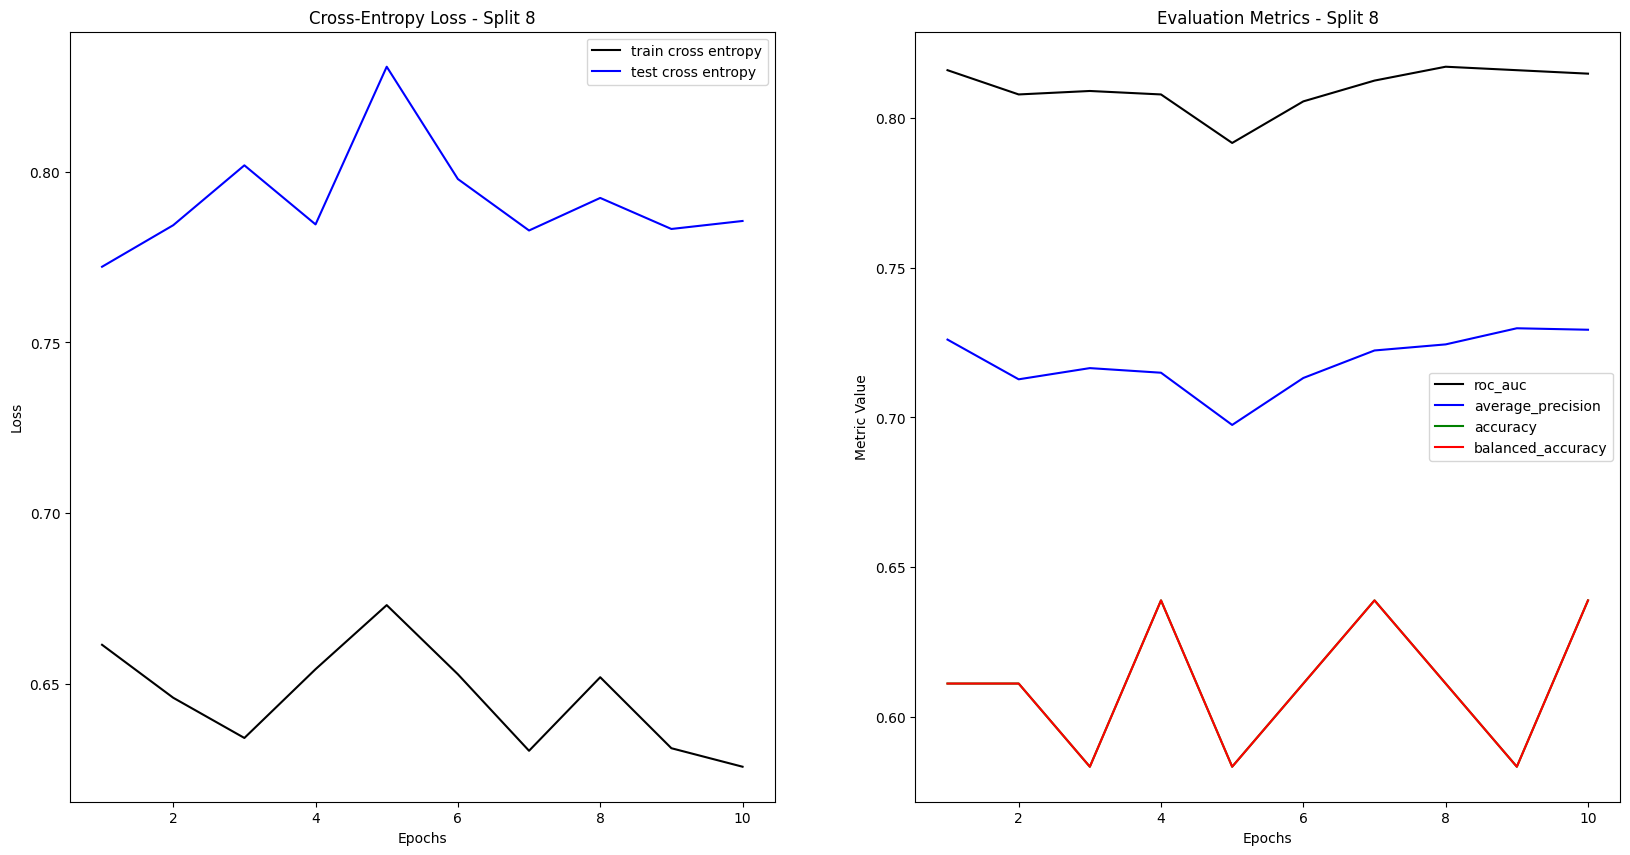

<Figure size 640x480 with 0 Axes>

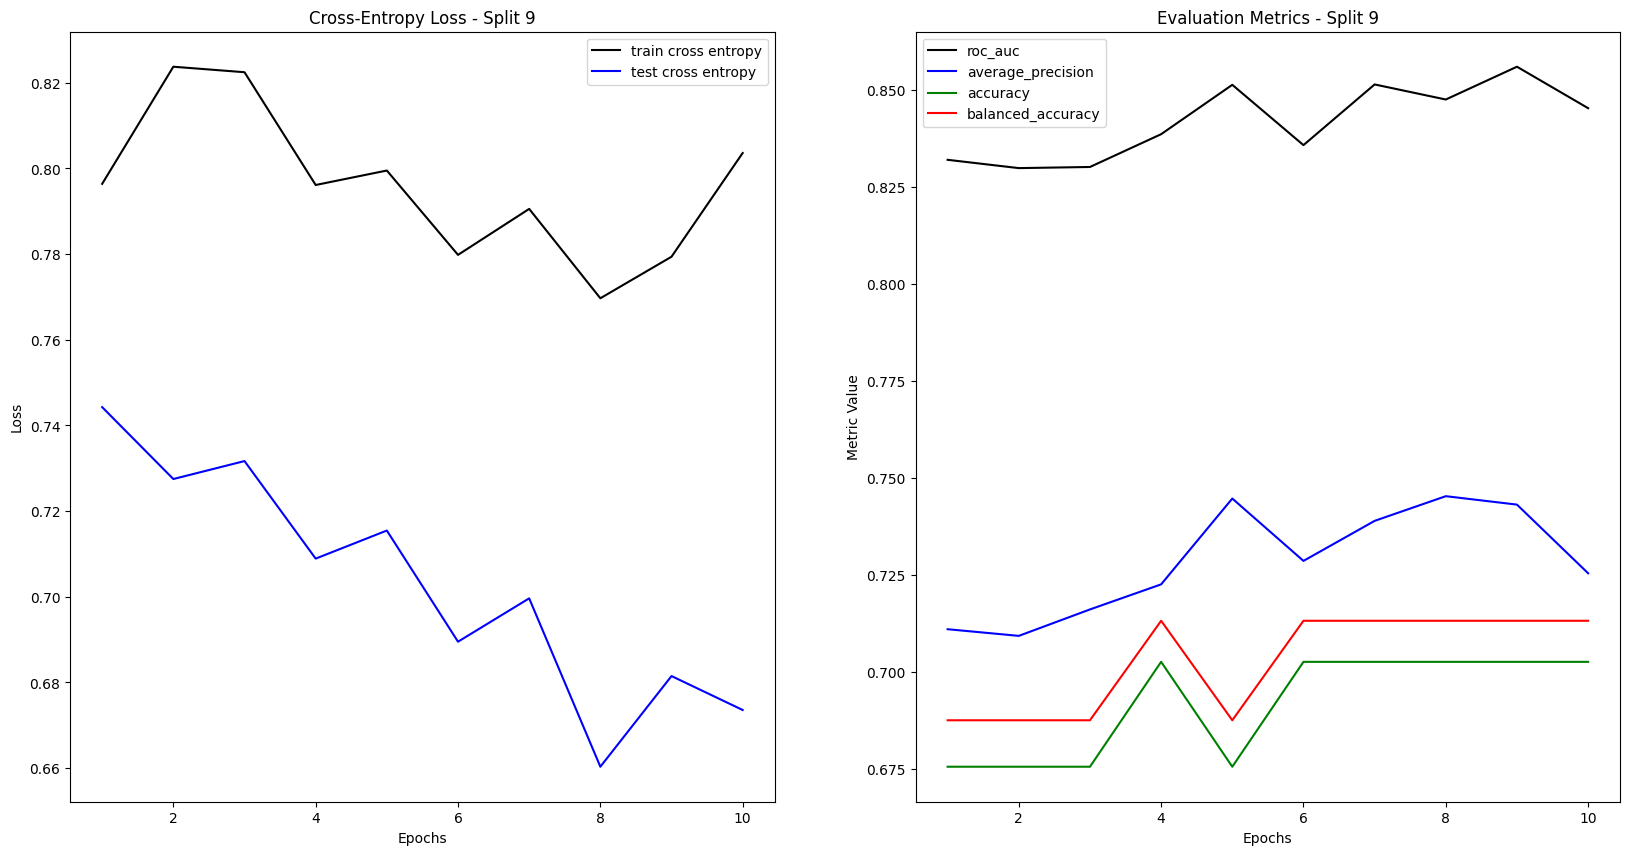

<Figure size 640x480 with 0 Axes>

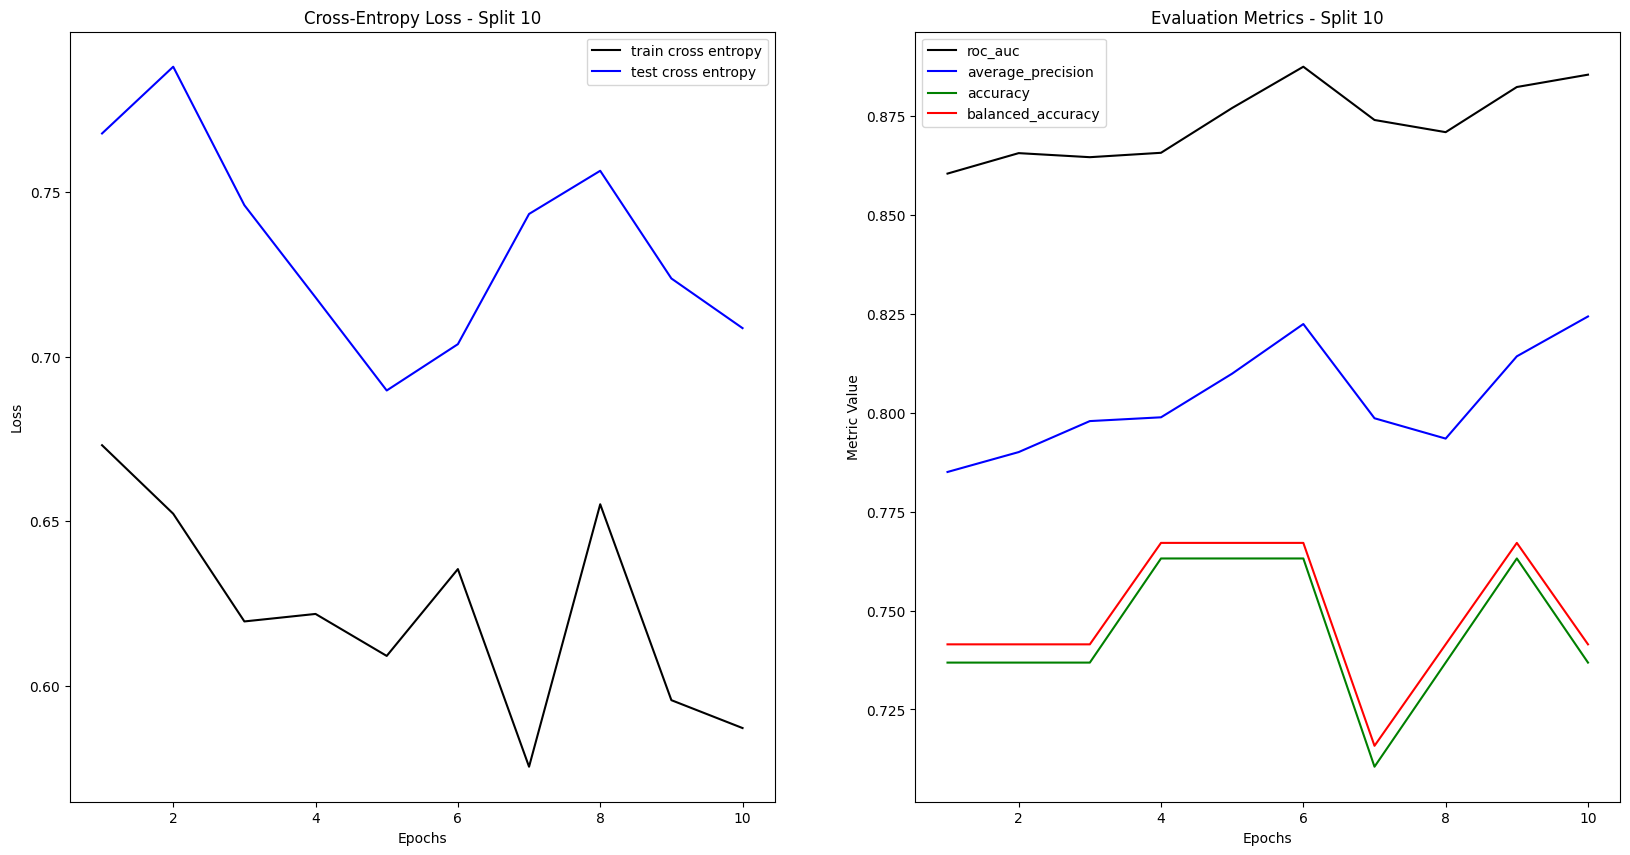

<Figure size 640x480 with 0 Axes>

In [13]:
for ix, res in enumerate(split_results):
    # Create a figure with one subplot (ncols=2)
    fig, ax = plt.subplots(ncols=2, sharex=True)
    fig.set_size_inches(20, 10)

    # x-axis values (epoch numbers)
    x = np.arange(1, num_epochs + 1)

    # Plot train and test loss for this split
    ax[0].plot(x, res['train_loss'], color='k', label='train cross entropy')
    ax[0].plot(x, res['test_loss'], color='b', label='test cross entropy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].set_title(f'Cross-Entropy Loss - Split {ix+1}')

    # Plot metrics for this split
    ax[1].plot(x, res['roc_auc'], color='k', label='roc_auc')
    ax[1].plot(x, res['average_precision'], color='b', label='average_precision')
    ax[1].plot(x, res['accuracy'], color='g', label='accuracy')
    ax[1].plot(x, res['balanced_accuracy'], color='r', label='balanced_accuracy')

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Metric Value')
    ax[1].legend()
    ax[1].set_title(f'Evaluation Metrics - Split {ix+1}')

    # Save the figure for each split
    plt.savefig(f'second_model_loss_and_metrics_split_test_{ix+1}.png', dpi=300, bbox_inches='tight')
    
    # Show the plots for the current split (optional, if you want to display them during each iteration)
    plt.show()
    
    # Clear the figure after saving to avoid overlap between plots
    plt.clf()

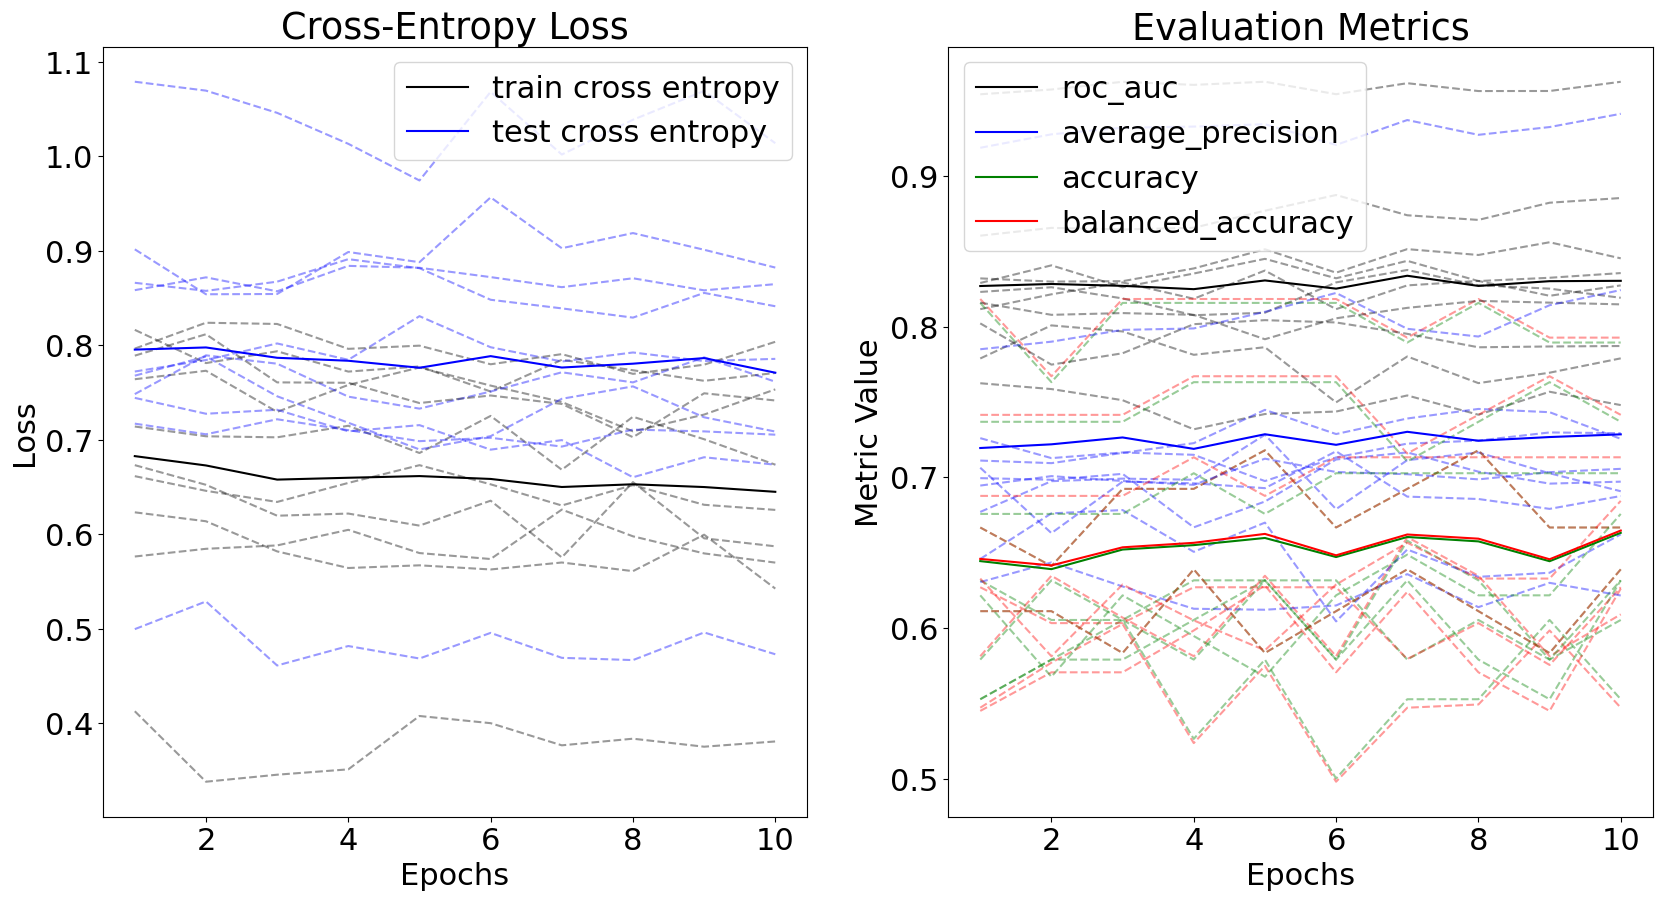

In [14]:
import matplotlib.pyplot as plt

# Example data
train_losses = np.array([res['train_loss'] for res in split_results])
test_losses = np.array([res['test_loss'] for res in split_results])
roc_aucs = np.array([res['roc_auc'] for res in split_results])
avg_precisions = np.array([res['average_precision'] for res in split_results])
accuracies = np.array([res['accuracy'] for res in split_results])
balanced_accuracies = np.array([res['balanced_accuracy'] for res in split_results])

# Set font size
plt.rcParams['font.size'] = 22

# Create a figure with one subplot (ncols=1)
fig, ax = plt.subplots(ncols=2, sharex=True)
fig.set_size_inches(20, 10)

# x-axis values (epoch numbers)
x = np.arange(1, num_epochs + 1)

# Plot each split result's train and test loss
for s in split_results:8
    ax[0].plot(x, s['train_loss'], color='k', linestyle='--', alpha=0.4)
    ax[0].plot(x, s['test_loss'], color='b', linestyle='--', alpha=0.4)

# Plot the average train and test loss on the first subplot
ax[0].plot(x, train_losses.mean(axis=0), color='k', label='train cross entropy')
ax[0].plot(x, test_losses.mean(axis=0), color='b', label='test cross entropy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_title('Cross-Entropy Loss')

# Plot the four metrics on the second subplot
for s in split_results:
    ax[1].plot(x, s['roc_auc'], color='k', linestyle='--', alpha=0.4)
    ax[1].plot(x, s['average_precision'], color='b', linestyle='--', alpha=0.4)
    ax[1].plot(x, s['accuracy'], color='g', linestyle='--', alpha=0.4)
    ax[1].plot(x, s['balanced_accuracy'], color='r', linestyle='--', alpha=0.4)

# Plot the average of the four metrics on the second subplot
ax[1].plot(x, roc_aucs.mean(axis=0), color='k', label='roc_auc')
ax[1].plot(x, avg_precisions.mean(axis=0), color='b', label='average_precision')
ax[1].plot(x, accuracies.mean(axis=0), color='g', label='accuracy')
ax[1].plot(x, balanced_accuracies.mean(axis=0), color='r', label='balanced_accuracy')

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Metric Value')
ax[1].legend()
ax[1].set_title('Evaluation Metrics')

plt.savefig(f'second_model_loss_and_metrics_test_final.png', dpi=300, bbox_inches='tight')
# Show the plots
plt.show()


In [16]:
torch.save(state_dict, 'num_head_2048.pth')

In [116]:
all_roc_auc = [split['roc_auc'][-1] for split in split_results]
roc_auc_array = np.array(all_roc_auc)
overall_mean = np.mean(roc_auc_array)
overall_std = np.std(roc_auc_array)
print(f"Overall ROC AUC = {overall_mean:.4f} ± {overall_std:.4f}")

Overall ROC AUC = 0.8289 ± 0.0652


In [117]:
with open('all_roc_auc_results2.txt', 'a') as f:  # 'a' for append mode
    f.write(f"Branches_{1}")  # Write branch number
    for value in all_roc_auc:
        f.write(f",{value}")  # Use comma as separator
    f.write("\n") 

In [118]:
from scipy import stats

all_roc_auc = [split['roc_auc'][-1] for split in split_results]
roc_auc_array = np.array(all_roc_auc)
overall_mean = np.mean(roc_auc_array)

# Calculate 90% confidence interval
confidence_level = 0.90
degrees_of_freedom = len(roc_auc_array) - 1
t_value = stats.t.ppf((1 + confidence_level) / 2, degrees_of_freedom)
margin_of_error = t_value * (np.std(roc_auc_array) / np.sqrt(len(roc_auc_array)))

print(f"Overall ROC AUC = {overall_mean:.4f} ± {margin_of_error:.4f} (90% CI)")

Overall ROC AUC = 0.8289 ± 0.0378 (90% CI)


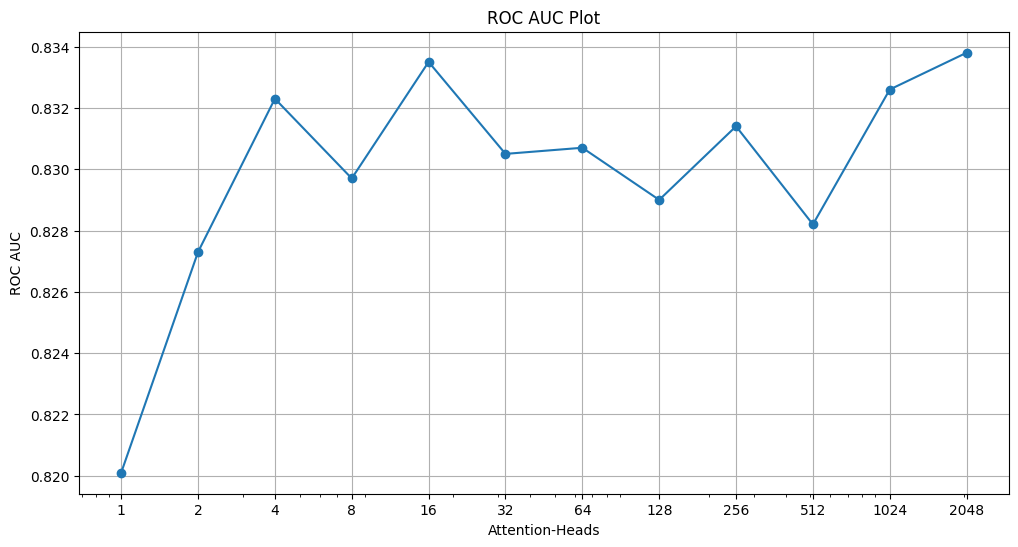

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# X-axis values
x_values = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
y_values = [0.8201, 0.8273, 0.8323, 0.8297, 0.8335, 0.8305, 0.8307, 0.8290, 0.8314, 0.8282, 0.8326, 0.8338]

plt.figure(figsize=(12, 6))
plt.plot(x_values, y_values, marker='o')
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel('Attention-Heads')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Plot')
plt.grid(True)

# Set x-ticks to our specific values
plt.xticks(x_values, [str(x) for x in x_values])
plt.savefig('Attention_plots.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

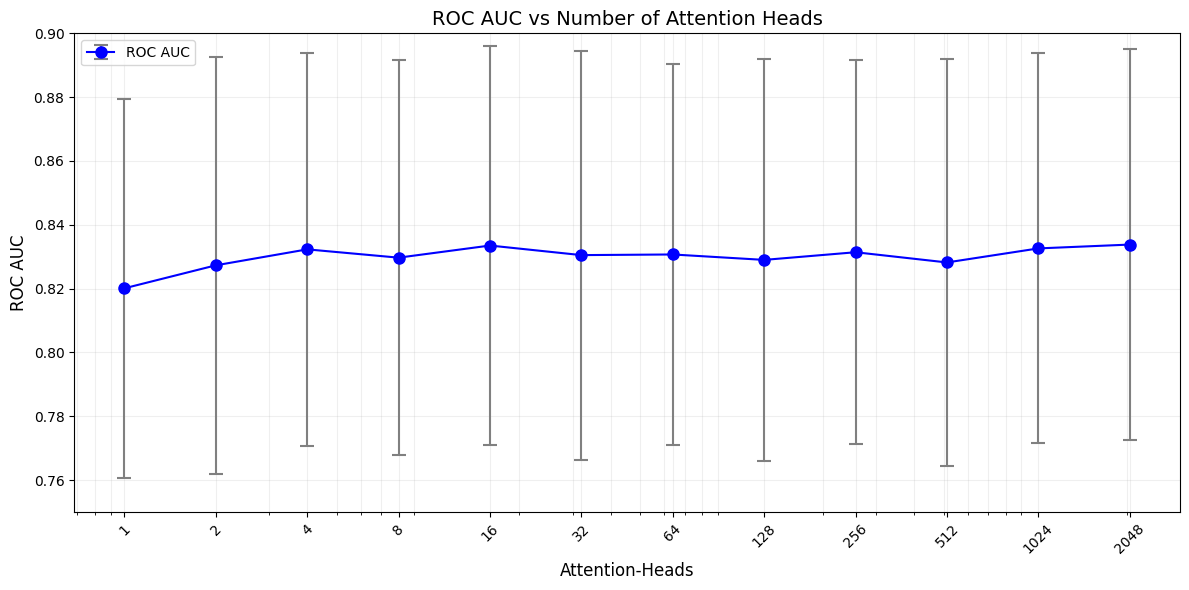

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# X-axis values
x_values = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
y_values = [0.8201, 0.8273, 0.8323, 0.8297, 0.8335, 0.8305, 0.8307, 0.8290, 0.8314, 0.8282, 0.8326, 0.8338]
yerr = [0.0593, 0.0654, 0.0616, 0.0619, 0.0626, 0.0641, 0.0596, 0.0631, 0.0602, 0.0639, 0.0611, 0.0612]

plt.figure(figsize=(12, 6))

# Create errorbar plot
plt.errorbar(x_values, y_values, 
            yerr=yerr,
            fmt='o-',           # format string: 'o' for dots, '-' for lines
            capsize=5,          # cap width for error bars
            capthick=1.5,       # cap thickness
            elinewidth=1.5,     # error bar line width
            markersize=8,       # size of markers
            color='blue',       # color of line and markers
            ecolor='gray',      # color of error bars
            label='ROC AUC')    # label for legend

plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel('Attention-Heads', fontsize=12)
plt.ylabel('ROC AUC', fontsize=12)
plt.title('ROC AUC vs Number of Attention Heads', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.2)

# Set x-ticks to our specific values
plt.xticks(x_values, [str(x) for x in x_values], rotation=45)

# Set y-axis limits to show the error bars clearly
plt.ylim(0.75, 0.90)  # Adjusted to accommodate error bars

# Add legend
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('Attention_plots_with_error_bars.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

[]


/home/xiaofey/.conda/envs/pytorch4d/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xiaofey/.conda/envs/pytorch4d/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/xiaofey/.conda/envs/pytorch4d/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/xiaofey/.conda/envs/pytorch4d/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/xiaofey/.conda/envs/pytorch4d/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NameError: name 'args' is not defined

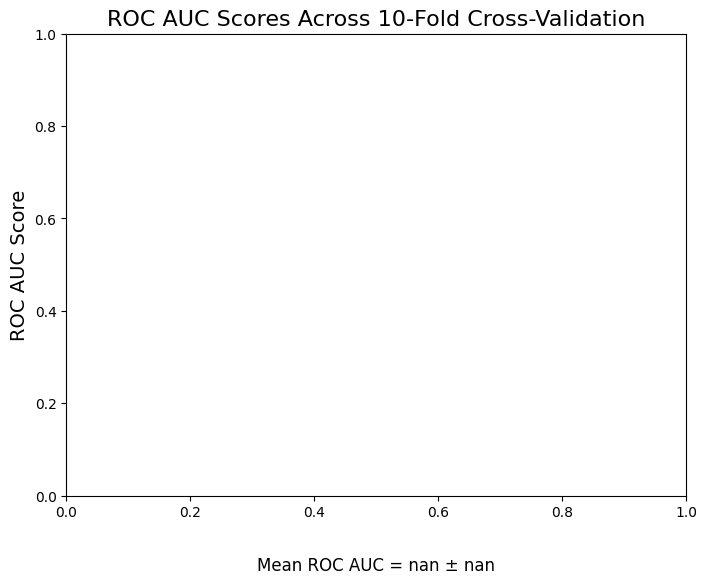

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Collect the final ROC AUC score for each fold
final_roc_auc_scores = [split['roc_auc'][-1] for split in split_results]

print(final_roc_auc_scores)

# Calculate overall statistics
overall_mean = np.mean(final_roc_auc_scores)
overall_std = np.std(final_roc_auc_scores)
# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(y=final_roc_auc_scores)

# Customize the plot
plt.title('ROC AUC Scores Across 10-Fold Cross-Validation', fontsize=16)
plt.ylabel('ROC AUC Score', fontsize=14)
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for AUC scores

# Remove x-axis label
plt.xlabel('')

# Add the mean ± std text
plt.text(0.5, -0.15, f"Mean ROC AUC = {overall_mean:.4f} ± {overall_std:.4f}", 
         horizontalalignment='center', verticalalignment='center', 
         transform=plt.gca().transAxes, fontsize=12)

# Save the figure
plt.savefig(os.path.join(args.plot_dir, 'roc_auc_overall_boxplot.png'), dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Print the scores for each fold
for i, score in enumerate(final_roc_auc_scores, 1):
    print(f"Fold {i}: ROC AUC = {score:.4f}")

In [15]:
import numpy as np

def extract_study_info(batch_info):
    patient_ids = batch_info['patient_id']
    attention_weights = batch_info['attention_weights']
    images = batch_info['images']
    labels = batch_info['labels']
    instance_labels = batch_info['instance_labels']
    predicted_labels = batch_info['predicted_labels']
    markers = batch_info['markers']

    print(f"Combined Batch Shape: {images.shape}")
    print(f"Combined Batch Labels: {labels}")
    print(f"Combined Instance Labels: {instance_labels}")
    print(f"Patient IDs: {patient_ids}")
    print(f"Markers: {markers}")

    for i in range(len(markers) - 1):
        start, end = markers[i], markers[i+1]
        
        study_images = images[start:end]
        study_instance_labels = instance_labels[start:end]
        study_attention_weights = attention_weights[i]  # Assuming attention_weights is already separated by study
        
        print(f"\nStudy {i+1} Information:")
        print(f"  Patient ID: {patient_ids[i]}")
        print(f"  Study Images Shape: {study_images.shape}")
        print(f"  Study Label: {labels[i]}")
        print(f"  Study Predicted Label: {predicted_labels[i]}")
        print(f"  Instance Labels: {study_instance_labels}")
        print(f"  Attention Weights Shape: {study_attention_weights.shape}")
        
        # Optional: Print first few attention weights
        if len(study_attention_weights) > 0:
            print(f"  First few attention weights: {study_attention_weights[:5]}")

# Example usage:
# Assuming batch_info is your dictionary with all the information
# extract_study_info(batch_info)

In [70]:
extract_study_info(batch_info_list)

Combined Batch Shape: (60, 1, 224, 224)
Combined Batch Labels: [1 2 1 1 0 2 0 1 2 2 0 2 1 2 1 0 2 0 1 1 0 1 1 2 2]
Combined Instance Labels: [1 1 2 2 2 1 1 1 1 0 0 0 2 2 2 0 1 1 1 2 2 2 0 0 2 2 1 2 1 1 1 0 0 0 2 2 2
 2 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 2 2 2 2 2]
Patient IDs: ['AN00019', 'AN00055', 'AN00065', 'AN00076', 'AN00093', 'AN00101', 'AN00102', 'AN00104', 'AN00108', 'AN00113', 'AN00114', 'AN00120', 'AN00122', 'AN00123', 'AN00131', 'AN00134', 'AN00142', 'AN00145', 'AN00167', 'AN00190', 'AN00218', 'AN00240', 'AN00241', 'AN00244', 'AN00258']
Markers: [0, 2, 5, 7, 9, 12, 15, 16, 19, 21, 22, 24, 26, 27, 28, 31, 34, 38, 40, 44, 47, 50, 52, 55, 58, 60]

Study 1 Information:
  Patient ID: AN00019
  Study Images Shape: (2, 1, 224, 224)
  Study Label: 1
  Study Predicted Label: 1
  Instance Labels: [1 1]
  Attention Weights Shape: (2, 1)
  First few attention weights: [[0.9977028]
 [0.0022972]]

Study 2 Information:
  Patient ID: AN00055
  Study Images Shape: (3, 1, 224, 224)
  Study Lab

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from matplotlib.backends.backend_pdf import PdfPages

def visualize_multiple_studies(batch_info_list, num_studies, save_path):
    # Ensure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    with PdfPages(save_path) as pdf:
        for batch_idx, batch_info in enumerate(batch_info_list):
            patient_ids = batch_info['patient_id']
            attention_weights = batch_info['attention_weights']
            images = batch_info['images']
            labels = batch_info['labels']
            predicted_labels = batch_info['predicted_labels']
            markers = batch_info['markers']
            
            print(f"\nBatch {batch_idx + 1} Information:")
            print(f"Total number of studies in this batch: {len(patient_ids)}")
            
            num_studies_to_show = min(num_studies, len(patient_ids))
            for study_idx in range(num_studies_to_show):
                start = markers[study_idx]
                end = markers[study_idx + 1] if study_idx + 1 < len(markers) else len(images)
                study_images = images[start:end]
                study_attention_weights = attention_weights[study_idx]
                
                print(f"\nStudy {study_idx + 1} Information:")
                print(f"  Patient ID: {patient_ids[study_idx]}")
                print(f"  True Label: {labels[study_idx]}")
                print(f"  Predicted Label: {predicted_labels[study_idx]}")
                
                num_images = len(study_images)
                fig, axs = plt.subplots(1, num_images, figsize=(4 * num_images, 4))
                
                if num_images == 1:
                    axs = [axs]
                
                for idx, (ax, image) in enumerate(zip(axs, study_images)):
                    if isinstance(image, torch.Tensor):
                        image = image.permute(1, 2, 0).cpu().numpy()
                    elif image.ndim == 3 and image.shape[0] == 1 or image.shape[0] == 3:
                        image = np.transpose(image, (1, 2, 0))
                    
                    if image.max() <= 1:
                        image = (image * 255).astype(np.uint8)
                    
                    ax.imshow(image, cmap='gray')
                    
                    if isinstance(study_attention_weights, (list, np.ndarray)) and len(study_attention_weights) == num_images:
                        weight = study_attention_weights[idx]
                        if isinstance(weight, (float, int, np.float32, np.float64)):
                            weight_str = f'{weight:.5f}'
                        else:
                            weight_str = str(weight)
                    else:
                        weight_str = 'N/A'
                    
                    ax.text(0.5, -0.05, weight_str, transform=ax.transAxes, color='red', ha='center', fontsize=10)
                    ax.axis('off')
                
                plt.suptitle(f"Batch {batch_idx + 1}, Study {study_idx + 1}\nPatient ID: {patient_ids[study_idx]}, True: {labels[study_idx]}, Pred: {predicted_labels[study_idx]}", 
                             fontsize=15, y=0.95)
                plt.tight_layout()
                plt.subplots_adjust(top=0.85)
                
                # Save the current figure to the PDF
                pdf.savefig(fig)
                plt.close(fig)  # Close the figure to free up memory
            
            break  # This will process only the first batch

    print(f"All plots have been saved to {save_path}")

In [13]:
import torch
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

def visualize_multiple_studies(batch_info_list, num_studies, save_path):
    # Ensure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    with PdfPages(save_path) as pdf:
        for batch_idx, batch_info in enumerate(batch_info_list):
            patient_ids = batch_info['patient_id']
            attention_weights = batch_info['attention_weights']
            images = batch_info['images']
            labels = batch_info['labels']
            predicted_labels = batch_info['predicted_labels']
            markers = batch_info['markers']
            
            print(f"\nBatch {batch_idx + 1} Information:")
            print(f"Total number of studies in this batch: {len(patient_ids)}")
            
            num_studies_to_show = min(num_studies, len(patient_ids))
            for study_idx in range(num_studies_to_show):
                start = markers[study_idx]
                end = markers[study_idx + 1] if study_idx + 1 < len(markers) else len(images)
                study_images = images[start:end]
                study_attention_weights = attention_weights[study_idx]
                
                print(f"\nStudy {study_idx + 1} Information:")
                print(f"  Patient ID: {patient_ids[study_idx]}")
                print(f"  True Label: {labels[study_idx]}")
                print(f"  Predicted Label: {predicted_labels[study_idx]}")
                
                num_images = len(study_images)
                fig, axs = plt.subplots(1, num_images, figsize=(5 * num_images, 5))
                
                if num_images == 1:
                    axs = [axs]
                
                for idx, (ax, image) in enumerate(zip(axs, study_images)):
                    if isinstance(image, torch.Tensor):
                        image = image.permute(1, 2, 0).cpu().numpy()
                    elif image.ndim == 3 and image.shape[0] == 1 or image.shape[0] == 3:
                        image = np.transpose(image, (1, 2, 0))
                    
                    if image.max() <= 1:
                        image = (image * 255).astype(np.uint8)
                    
                    ax.imshow(image, cmap='gray')
                    ax.axis('off')
                    
                    if isinstance(study_attention_weights, (list, np.ndarray)) and len(study_attention_weights) == num_images:
                        weight = study_attention_weights[idx]
                        if isinstance(weight, (float, int, np.float32, np.float64)):
                            weight_str = f'{weight:.7f}'
                        else:
                            weight_str = str(weight)
                    else:
                        weight_str = 'N/A'
                    
                    ax.text(0.5, -0.05, weight_str, transform=ax.transAxes, color='red', ha='center', va='top', fontsize=30)
                
                plt.suptitle(f"Batch {batch_idx + 1}, Study {study_idx + 1}\nPatient ID: {patient_ids[study_idx]}, True: {labels[study_idx]}, Pred: {predicted_labels[study_idx]}", 
                             fontsize=22, y=0.98)
                plt.tight_layout()
                plt.subplots_adjust(top=0.85, bottom=0.15)
                
                # Save the current figure to the PDF
                pdf.savefig(fig)
                plt.close(fig)  # Close the figure to free up memory
            
            break  # This will process only the first batch
    print(f"All plots have been saved to {save_path}")

In [18]:
visualize_multiple_studies(split_results[3]['batch_info'][0], 10, '/home/xiaofey/xray/xray-master/code/image.pdf')


Batch 1 Information:
Total number of studies in this batch: 25

Study 1 Information:
  Patient ID: AN00002
  True Label: 0
  Predicted Label: 0

Study 2 Information:
  Patient ID: AN00005
  True Label: 0
  Predicted Label: 1

Study 3 Information:
  Patient ID: AN00011
  True Label: 2
  Predicted Label: 2

Study 4 Information:
  Patient ID: AN00013
  True Label: 1
  Predicted Label: 0

Study 5 Information:
  Patient ID: AN00038
  True Label: 1
  Predicted Label: 0

Study 6 Information:
  Patient ID: AN00042
  True Label: 2
  Predicted Label: 2

Study 7 Information:
  Patient ID: AN00056
  True Label: 2
  Predicted Label: 2

Study 8 Information:
  Patient ID: AN00057
  True Label: 0
  Predicted Label: 2

Study 9 Information:
  Patient ID: AN00066
  True Label: 2
  Predicted Label: 2

Study 10 Information:
  Patient ID: AN00080
  True Label: 0
  Predicted Label: 0
All plots have been saved to /home/xiaofey/xray/xray-master/code/image.pdf


In [17]:
import numpy as np
import pickle
import os

# Function to process metrics
def process_metric(metric_name):
    all_scores = [split[metric_name][-1] for split in split_results]
    scores_array = np.array(all_scores)
    overall_mean = np.mean(scores_array)
    overall_std = np.std(scores_array)
    print(f"Overall {metric_name} = {overall_mean:.4f} ± {overall_std:.4f}")
    return all_scores, overall_mean, overall_std

# Process each metric
metrics = ['roc_auc', 'accuracy', 'average_precision', 'balanced_accuracy']
results = {}

for metric in metrics:
    scores, mean, std = process_metric(metric)
    results[metric] = {
        'scores': scores,
        'mean': mean,
        'std': std
    }
    
    # Print the scores for each fold
    for i, score in enumerate(scores, 1):
        print(f"Fold {i}: {metric} = {score:.4f}")

with open('MIL4_metric_results.txt', 'w') as f:
    for metric in metrics:
        scores, mean, std = process_metric(metric)
        results[metric] = {
            'scores': scores,
            'mean': mean,
            'std': std
        }
        
        # Write overall result to file
        f.write(f"Overall {metric} = {mean:.4f} ± {std:.4f}\n")
        
        # Write individual fold scores to file
        f.write("Individual fold scores:\n")
        for i, score in enumerate(scores, 1):
            f.write(f"Fold {i}: {score:.4f}\n")
        
        f.write("\n")  # Add a blank line between metrics

print("All metrics processed and saved to MIL4_metric_results.txt")

Overall roc_auc = 0.6142 ± 0.0984
Fold 1: roc_auc = 0.5894
Fold 2: roc_auc = 0.3755
Fold 3: roc_auc = 0.6686
Fold 4: roc_auc = 0.7161
Fold 5: roc_auc = 0.7261
Fold 6: roc_auc = 0.5301
Fold 7: roc_auc = 0.6501
Fold 8: roc_auc = 0.5903
Fold 9: roc_auc = 0.6806
Fold 10: roc_auc = 0.6152
Overall accuracy = 0.3951 ± 0.0791
Fold 1: accuracy = 0.3421
Fold 2: accuracy = 0.2632
Fold 3: accuracy = 0.4615
Fold 4: accuracy = 0.4211
Fold 5: accuracy = 0.5526
Fold 6: accuracy = 0.3158
Fold 7: accuracy = 0.4054
Fold 8: accuracy = 0.3611
Fold 9: accuracy = 0.4595
Fold 10: accuracy = 0.3684
Overall average_precision = 0.5009 ± 0.0793
Fold 1: average_precision = 0.4357
Fold 2: average_precision = 0.3175
Fold 3: average_precision = 0.5652
Fold 4: average_precision = 0.5603
Fold 5: average_precision = 0.5935
Fold 6: average_precision = 0.4295
Fold 7: average_precision = 0.5264
Fold 8: average_precision = 0.5159
Fold 9: average_precision = 0.5516
Fold 10: average_precision = 0.5132
Overall balanced_accurac

In [16]:
with open('MIL4_metric_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Access results like this:
roc_auc_mean = results['roc_auc']['mean']
accuracy_std = results['accuracy']['std']
print(roc_auc_mean)

0.6142014928586835


In [136]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Read the data
results = {}
with open('all_roc_auc_results2.txt', 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        n_heads = int(parts[0].split('_')[1])  # Extract number after "Branches_"
        auc_values = np.array([float(x) for x in parts[1:]])
        results[n_heads] = auc_values

# Get baseline (1 head) results
baseline = results[1]

In [137]:
baseline

array([0.77666667, 0.72376068, 0.7495069 , 0.89213675, 0.84269231,
       0.7967033 , 0.91135888, 0.8125    , 0.85751748, 0.92568376])

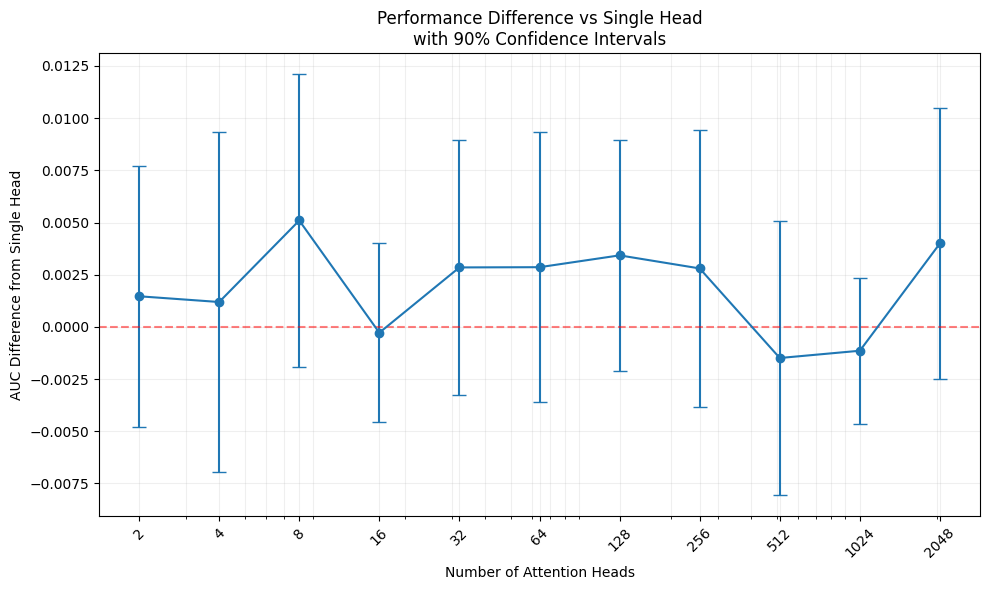

In [131]:
differences = {}
ci_90 = {}

for n_heads, values in results.items():
    if n_heads == 1:
        continue
        
    # Calculate paired differences
    diff = values - baseline
    
    # Calculate mean difference
    mean_diff = np.mean(diff)
    
    # Calculate 90% confidence interval
    # Using t-distribution because small sample size
    t_stat = stats.t.ppf(0.95, len(diff)-1)  # 90% CI = 0.95 quantile
    se = np.std(diff, ddof=1) / np.sqrt(len(diff))
    ci = (mean_diff - t_stat*se, mean_diff + t_stat*se)
    
    differences[n_heads] = mean_diff
    ci_90[n_heads] = ci

# Plotting
plt.figure(figsize=(10, 6))

# Sort heads for x-axis
head_numbers = sorted(differences.keys())
means = [differences[n] for n in head_numbers]
ci_lower = [ci_90[n][0] for n in head_numbers]
ci_upper = [ci_90[n][1] for n in head_numbers]

# Create error bars
plt.errorbar(head_numbers, means, 
            yerr=[np.array(means)-np.array(ci_lower), 
                  np.array(ci_upper)-np.array(means)],
            fmt='o-', capsize=5)

# Add horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.xscale('log')  # Since heads increase exponentially
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xticks(head_numbers, [str(x) for x in head_numbers], rotation=45)

plt.xlabel('Number of Attention Heads')
plt.ylabel('AUC Difference from Single Head')
plt.title('Performance Difference vs Single Head\nwith 90% Confidence Intervals')

# Annotate significant differences
for n, mean, ci_l, ci_u in zip(head_numbers, means, ci_lower, ci_upper):
    if ci_l > 0:  # Both CI bounds above 0
        plt.annotate('*', (n, mean), 
                    xytext=(0, 10), textcoords='offset points',
                    ha='center')
plt.savefig('Attention_plots_with_error_bars_updated.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()